In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D

from astropy import units as u
from astropy import constants as const
import glob
#import yt
#from yt.units import kpc
#import ytree
from matplotlib.patches import Rectangle
import pandas as pd
import time
from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.interpolate import griddata
from scipy import interpolate
CMAP = cm.coolwarm
# import hmf
# from hmf import MassFunction
from scipy import special


import random
from scipy.stats import poisson
import astropy
import io
from astropy.constants import G
from scipy.interpolate import NearestNDInterpolator
import math
from astropy.cosmology import WMAP9 as cosmo
import scipy.interpolate as intp

# Luminosity Function, I could potentially add this to our bh growth comparison

In [34]:
def bolometric_correction(logLbol):
    c1, c2 = 1.862, 4.876
    k1, k2 = -0.361, -0.0063
    L = 10 ** logLbol
    Lsun = 3.839 * 1e33
    LbolLband = c1 * (L / (1e10 * Lsun)) ** k1 + c2 * (L / (1e10 * Lsun)) ** k2
    return np.log10(LbolLband)

def dispersion(logLbol):
    sig1, sig2, logL0, sig3 = -0.372, 0.405, 42.31, 2.310
    import scipy.special as ss
    err_func = ss.erf((logLbol - logL0) / (np.sqrt(2) * sig3))
    sigma = sig2 + sig1 * ((1/2) + (1/2) * err_func)
    return sigma

def L1450_wStdev(logLbol):
    C = bolometric_correction(logLbol)
    logL1450 = logLbol - C
    mean_corr = logL1450
    stdev = dispersion(logLbol)
    corr_upp, corr_low = logLbol + stdev, logLbol - stdev
    return mean_corr, corr_upp, corr_low

def M1450(logLbol):
    Lsun = 3.839 * 1e33
    Msun = 4.83
    L_1450 = 10 ** L1450_wStdev(logLbol)[0]
    return -2.5 * np.log10(L_1450 / Lsun) + Msun

def Mbh(i_mag, q_s):
    # compute Mbh at z=2, from Haiman et al. 2009
    bh_mass = 3 * 1e6 * 10 ** ((24-i_mag) / 2.5)
    # print(np.log10(bh_mass))
    logM1 = bh_mass / (1 + q_s)
    return np.log10(logM1) # in unit of Msun

def imag(logM1, q_s,z):
    f_edd = 0.01
    d_z = float(cosmo.luminosity_distance(z) / (u.parsec))
    d_2 = float(cosmo.luminosity_distance(2) / (u.parsec))
    return 26 + 2.5 * np.log10((f_edd / 0.01) ** (-1) * (10 ** logM1 / (3 * 1e7)) ** (-1) * (d_z / d_2) ** 2)

def volume(z, area):
    omega = (area/41253.0)*4.0*np.pi # str
    vol_perstr = cosmo.differential_comoving_volume(z) # cMpc^3 str^-1 dz^-1
    volperstr = float(vol_perstr * u.sr * (1e6*u.parsec)**(-3))
    return omega*volperstr 

def m(M1450,z,linear):
    # M1450 is absolute magnitude, Kcorr is i-band K-correction to m at 1450 A.
    # From z, find luminosity distance in Mpc.
    D = cosmo.luminosity_distance(z)
    D_L = float(D / (u.parsec))  # luminosity distance in Mpc.
    # print(D_L)
    if z <= 4.700:
        ind = np.where(z_1 == z)[0]
        # print(ind)
        Kcorr = kcorri_1[ind]
        # print(Kcorr)
    if z > 4.700:
        if linear == True:
            # Kcorr = -2.2
            f = np.poly1d(np.polyfit(z_1,kcorri_1, 1))
            Kcorr = f(z)

            # f = intp.interp1d(z_1,kcorri_1,fill_value='extrapolate')
            # Kcorr = f(z)
            # Kcorr = np.interp(z, z_1, kcorri_1)
            # print(Kcorr)
        else:
            Kcorr = -2.2
    # return K/corr
    m = M1450 + 5 * np.log10(D_L / 1e6) + 25 + Kcorr
    return m

H0 = 70 
Omega_m, Omega_lambda = 0.3, 0.7
c = 2.998 * 1e10
ratio = 0.1

kcorri_l15 = np.loadtxt('lum_func/kcorr_imag_kulkarni2019/kcorri_l15.txt')
kcorri_t02 = np.loadtxt('lum_func/kcorr_imag_kulkarni2019/kcorri_t02.txt')
kcorri_v01 = np.loadtxt('lum_func/kcorr_imag_kulkarni2019/kcorri_v01.txt')
z_1, kcorri_1 = kcorri_l15[:,1], kcorri_l15[:,2]
z_2, kcorri_2 = kcorri_t02[:,1], kcorri_t02[:,2]
z_3, kcorri_3 = kcorri_v01[:,1], kcorri_v01[:,2]

# Constants 

In [2]:

OMEGA_B = 0.0486 
OMEGA_M = 0.307
OMEGA_L = 1-OMEGA_M
SIGMA_8 = 0.81
delta_c = 1.686
h=0.677
rho_crit = 1.5*1e11 #Msol/mpc^3
T_HUBBLE = 4.55e17 #s
MPC_TO_CM = 3.086e+24

K = 1.380649e-16 #ergs/K
SEC_PER_MYR = 3.15576e+13
m_p = 1.6e-27
msol = 2e30
mpc = 3.086e+24
n = rho_crit*msol/mpc**3*OMEGA_B/m_p #cm^-3



# u=1.22
N_GAS=0.2

# Probability of forming a leo-like candidate as a function of criteria

### Keep this section closed, it was a test for the full script that is now on the cluster

In [5]:
r_leo = 250*u.kpc #kpc, not radius of leo but distance between leo and mw
mass_MW = 0.9e12*u.Msun
mass_Leo = 7e8*u.Msun
mass_tolerance = 1e8*u.Msun
mt = mass_tolerance

tff = np.pi/2.0 * (np.power(r_leo,1.5)/np.sqrt(2*G*(mass_MW +mass_Leo)))
tff = tff.to("Myr")/2.0 #taking half the ff time
tff
#T_vir(mass_Leo.value, 10)

def get_redshift(file):
    f = open(file, "r")
    z=[]
    for line in f:
        a=float(line.strip("\n"))
        z.append(1/a - 1)
    return z

def z_to_time(z):
        a=2./(3.*np.sqrt(OMEGA_L))
        b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
        c = 71*1e5*3.154e+7/3.086e18
        return a/c*np.log(b+np.sqrt(1+b*b))

def T_vir(m,z):
    h=0.7 
    
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    return 1.98e4*(u/0.6)*np.float_power(m*h/1e8, 2.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0


def T_vir_inverted(T,z):
    h=0.7
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    m = np.float_power(T/(1.98e4*(u/0.6)) / (np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0),3.0/2)*1e8/h
    return m

def get_all_progs(inds, prog, prog2, i):
    prog_id1 = prog[i]
    prog_id2 = prog2[i]
    list_ = [i]
#     print(prog_id2 in inds)
#     print(prog_id1, prog_id2)
    if((prog_id1 == -1) or (prog_id1 not in inds)): return list_
    if(prog_id2 != -1): 
        if(prog_id2 in inds):
            prog_id2 =np.where(inds ==prog_id2)[0][0]
            list_.extend(get_all_progs(inds, prog, prog2, prog_id2))
    prog_id1 =np.where(inds ==prog_id1)[0][0]
    list_.extend(get_all_progs(inds,prog, prog2, prog_id1))
    return list_


def save_data(data,savename="leo_candidacy"):
    columns = ['merger_ratio', 'target_temp', 'min_t_ratio', 'count']
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(savename,index=False)
    
def get_grid_ind(x,y,z):
    return TEMP_N*TCOOL_N* x + TCOOL_N*y + z



def make_grid():
    m_list, temp_list, tratio_list = [],[],[]
    count_list = []
    for x in range(MERGER_N):
        for y in range(TEMP_N):
            for z in range(TCOOL_N):
                m_list.append(MERGER_RANGE[x])
                temp_list.append(TEMP_RANGE[y])
                tratio_list.append(TCOOL_RANGE[z])
                count_list.append(0)
    m_list = np.array(m_list)
    temp_list = np.array(temp_list)
    tratio_list = np.array(tratio_list)
    count_list = np.array(count_list)
    grid = np.array([m_list, temp_list, tratio_list, count_list]).T
    return grid
    


def find_leo_dcbhs(grid):
    dcbh_files = np.sort(list(glob.iglob("dcbh_files/*.csv")))
    print(dcbh_files)
    inds_keep = []
    for f in dcbh_files:#range(Ntrees):

        ds =  pd.read_csv(f,delimiter=",",skiprows = 1, names=["filler","ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10", "jlw", "t_cools", "tcool/thub"])

        inds = np.array(ds["ind"])
        z = get_redshift("Snapshot_alist_mod")
        snaps = np.array(ds["snap_num"])
        zs = np.array(z)[snaps]
        mass = np.array(ds["mass/1e10"]*1e10)
        t_ratio = np.array(ds["tcool/thub"])
        
        inds = np.array(ds["ind"])
        desc = np.array(ds["desc"])
        prog = np.array(ds["first_prog"])
        prog2 = np.array(ds["next_prog"])
        times=z_to_time(zs)
        tvirs = T_vir(mass,zs)

        selection_filter = np.where((times >= (np.max(times)-tff.value)) & (mass <= (mass_Leo+mt).value) & (mass >= (mass_Leo-mt).value))
        filtered_mass = mass[selection_filter]
        filtered_progs = prog[selection_filter]
        filtered_inds = inds[selection_filter]

        if(np.size(selection_filter) == 0): continue
        #remove duplicate candidates (different snaps of the same halo)    
        branch_ids = []
        for x,current_prog in zip(range(len(filtered_progs)), filtered_progs):

            if any(current_prog in sub_branch for sub_branch in branch_ids): continue
            this_progs_ids = [filtered_inds[x]]
            prog_i = filtered_progs[x]

            while(True):
                index = np.where(inds == prog_i)[0]
                if(index.size == 0): break
                this_progs_ids.append(prog_i)

                prog_i = prog[index[0]]

            branch_ids.append(this_progs_ids)


        #find the number of leo candidates
        max_mergers = 3
        data = []
        for x in range(MERGER_N):
            for y in range(TEMP_N):
                for z in range(TCOOL_N):
                    grid_ind = get_grid_ind(x,y,z)
                    merger_ratio, target_temp, min_t_ratio, count = grid[grid_ind]
                    print("working on mr, tt, mt:", merger_ratio, target_temp, min_t_ratio)
                    for sub_branch in branch_ids:
                        indices = []
                        for ind in sub_branch:
                            a=np.where(inds ==ind)[0][0]
                            indices.append(a)
                        branch_mass = mass[indices]
                        branch_z = zs[indices]
                        branch_tvirs= tvirs[indices]

                        tvir_filter = np.where(branch_tvirs >= target_temp)[0]
                        branch_mass = branch_mass[tvir_filter]
                        branch_z = branch_z[tvir_filter]

                        index_of_ach = (np.array(indices)[tvir_filter])[-1]
                        #print(tvirs[index_of_ach], zs[index_of_ach], mass[index_of_ach])
                        index_of_ach = np.where(inds ==prog[index_of_ach])[0][0] 
                        #print(tvirs[index_of_ach], zs[index_of_ach], mass[index_of_ach])

                        large_merger_count = 0
                        for xi in range(len(branch_mass) -1):
                            if(branch_mass[xi] >= merger_ratio* branch_mass[xi+1]):
                                large_merger_count += 1
                        lmc = large_merger_count
                        if((lmc <= max_mergers) and (lmc > 0)): 
                            #check the cooling times
                            #get all the progs
                            locations = []
                            locations.extend(get_all_progs(inds,prog, prog2, index_of_ach))
                            ach_t_ratio = t_ratio[locations]
                            if(np.all(ach_t_ratio > min_t_ratio)):             
                                count += 1
                                
                        grid[grid_ind][-1] = count



                
                
                
                
    
    return grid

# MERGER_N = 3
# TEMP_N = 3
# TCOOL_N = 3
# MERGER_RANGE = np.linspace(1.1, 2, MERGER_N)
# TEMP_RANGE = np.linspace(4e3, 1e4, TEMP_N)
# TCOOL_RANGE = np.linspace(0.05, 1.0, TCOOL_N)

# grid = make_grid()
# grid = find_leo_dcbhs(grid)

# save_data(grid)
# df = pd.read_csv("leo_candidacy")
# df

# Script for combining leo cand files

In [6]:
# all_files = list(glob.iglob("leo_candidacy_files/*"))
# num_files = np.size(all_files)
# df = pd.read_csv(all_files[0])
# mr, tt, mt, count = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
# count = np.zeros(np.size(count))
# file_count = 0
# for f in all_files:
    
#     df = pd.read_csv(f)
#     mr, tt, mt, count_temp = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
#     if(np.size(count_temp) == 4000):
#         count = count+count_temp
#         file_count += 1

# count_av = count#*1.0/num_files

# save_data(np.array([mr,tt,mt, count_av]).T, savename = "leo_candidacy")

# Figure 1 probability plot

In [3]:
df = pd.read_csv("leo_candidacy")

mr, tt, mt, count = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
file_count=1000
df

,merger_ratio,target_temp,min_t_ratio,count
0,1.1,4000.0,0.050000,5.0
1,1.1,4000.0,0.155556,3.0
2,1.1,4000.0,0.261111,3.0
3,1.1,4000.0,0.366667,3.0
4,1.1,4000.0,0.472222,2.0
...,...,...,...,...
3995,2.0,10000.0,0.577778,0.0
3996,2.0,10000.0,0.683333,0.0
3997,2.0,10000.0,0.788889,0.0
3998,2.0,10000.0,0.894444,0.0


C:\Users\matth\AppData\Local\Temp\ipykernel_18356\1817223856.py:133: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  cs = ax.contour(x.reshape(nx,ny),y.reshape(nx,ny),vals.reshape(nx,ny),levels=[-2,-1,0,0.4771212],colors="black",linestlyes=["dashed" for x in range(4)])#,vmin=-2,vmax=0.1)
C:\Users\matth\AppData\Local\Temp\ipykernel_18356\1817223856.py:133: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  cs = ax.contour(x.reshape(nx,ny),y.reshape(nx,ny),vals.reshape(nx,ny),levels=[-2,-1,0,0.4771212],colors="black",linestlyes=["dashed" for x in range(4)])#,vmin=-2,vmax=0.1)
C:\Users\matth\AppData\Local\Temp\ipykernel_18356\1817223856.py:133: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  cs = ax.contour(x.reshape(nx,ny),y.reshape(nx,ny),vals.reshape(nx,ny),levels=[-2,-1,0,0.4771212],colors="black",linestlyes=["dashed" for x in range(4)])#,vmin=-2,vmax=0.1)


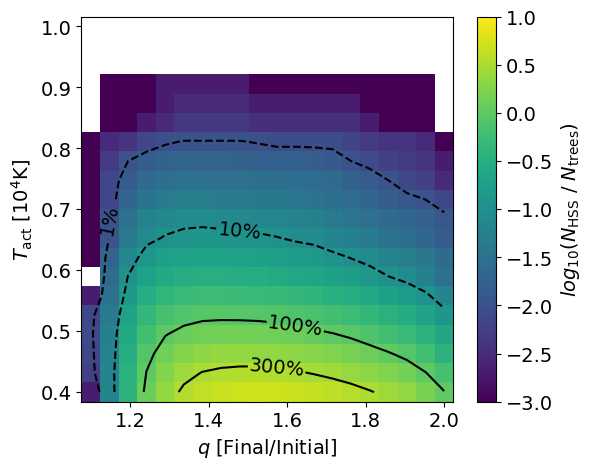

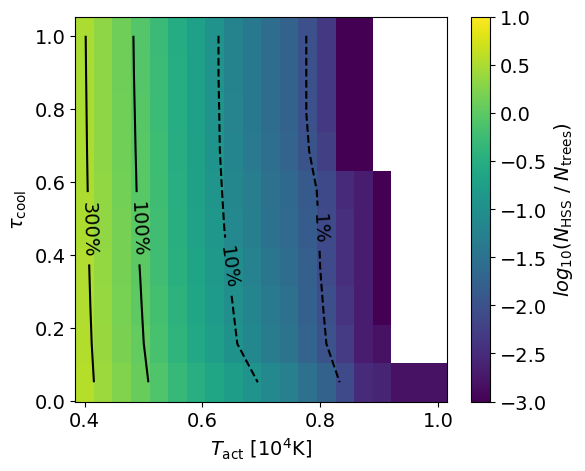

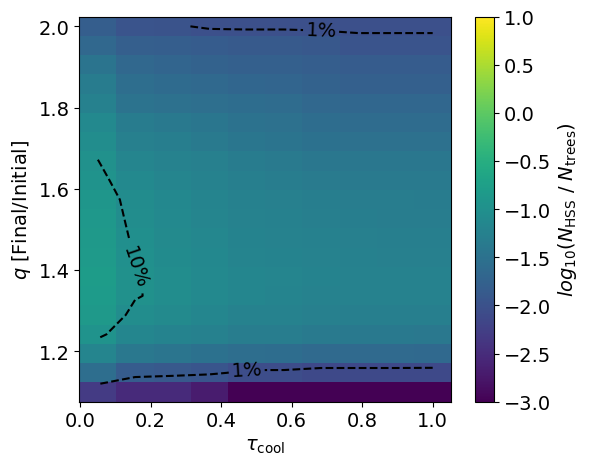

In [8]:
plt.rcParams.update({'font.size': 14})


MERGER_N = 20
TEMP_N = 20
TCOOL_N = 10
MERGER_RANGE = np.linspace(1.1, 2, MERGER_N)
TEMP_RANGE = np.linspace(4e3, 1e4, TEMP_N)/10000
TCOOL_RANGE = np.linspace(0.05, 1.0, TCOOL_N)

RANGE = [MERGER_RANGE, TEMP_RANGE, TCOOL_RANGE]
NUMBERS = [MERGER_N, TEMP_N, TCOOL_N]
LABELS = [r"$q$ [Final/Initial]", r"$T_{\rm act}$ [$10^4$K]", r"$\tau_{\rm cool}$"]
SAVENAMES = ["merger_ratio_vs_temp", "temp_vs_tcoolthub_ratio", "tcoolthub_ratio_vs_merger_ratio" ]





def prep_data(data_name):
    df = pd.read_csv(data_name)
    mr, tt, mt, count = np.array(df["merger_ratio"]), np.array(df["target_temp"])/10000, np.array(df["min_t_ratio"]), np.array(df["count"])
    #print(mr)
    count_av = []
    count_median = []
    count_max = []
    x,y, = [],[]
    data = [mr,tt,mt]


    r1,r2,r3 = RANGE[a], RANGE[b], RANGE[c]
    d1,d2,d3 = data[a], data[b], data[c]
     
    for r1v in r1:
        for r2v in r2:
            x.append(r1v)
            y.append(r2v)
            filter_ = np.where((np.abs(d1-r1v)<0.0001) & (np.abs(d2-r2v)<0.0001))
            r3_av = np.median(d3[filter_])
            #print(r3_av)
            count_av.append(np.mean(count[filter_]))
            count_median.append(np.median(count[filter_]))
#             print(count[filter_])
#             print(r1v, r2v)
#             print(d1,d2)
            count_max.append(np.max(count[filter_]))
    return np.array(x),np.array(y),np.array(count_av),np.array(count_median),np.array(count_max), r3_av
            
def get_contour(x,y,z):
    points = np.array([x,y]).T
    interpolator = NearestNDInterpolator(points, z)
    xdif, ydif
    xup,xlo
    yup,ylo
    target = 0.1
    nx,ny = round((xup-xlo)/xdif),round((yup-ylo)/ydif)
    x_interp, y_interp = [],[]

    for xit in  range(nx-1):
        for yit in range(ny-1):
            x1,y1 = xlo+xit*xdif+xdif/2,ylo+yit*ydif+ydif/2
            x2,y2 = x1+xdif, y1+ydif
            interp_points = [[x1,y1], [x1,y2], [x2,y2], [x2,y1]]
            interp_colors = interpolator(interp_points)
            ic = interp_colors
            if(target < np.min(ic) or target > np.max(ic)): continue
            for ind in range(4):
                p1,p2 = interp_points[ind], interp_points[(ind+1)%4]
                a,b=interp_colors[ind],interp_colors[(ind+1)%4]
                vals = [a,b]
                if(target<=np.max(vals) and target>=np.min(vals)):
                    if(np.abs(p1[0] - p2[0]) < 0.0001): 
                        m = (vals[1]-vals[0])/ydif
                        x_interp.append(p1[0])
                        y_interp.append((target-vals[0])/m + p1[1])

                    else: 
                        m = (vals[1]-vals[0])/xdif
                        x_interp.append((target-vals[0])/m + p1[0])
                        y_interp.append(p1[1])
    return x_interp, y_interp          

NUM_TREES =   file_count

FNAME = "leo_candidacy"
cm = plt.get_cmap('viridis') 

i=0  #0, collapse tcool param, 1 temp, 2 merger
for i in range(3):
    a,b,c = i,(i+1)%3, (i+2)%3


    x,y,cav,cmed, cmax, mean_collapse = prep_data(FNAME)
    num_x, num_y = NUMBERS[a], NUMBERS[b]
    xlabel,ylabel = LABELS[a], LABELS[b]
    x_range,y_range = RANGE[a], RANGE[b]
    savename = SAVENAMES[a]


    title = "Grid Size = "+str(num_x)+"x"+str(num_y)  
    xdif, ydif = x_range[1]-x_range[0], y_range[1]-y_range[0]
    xup,xlo = x_range[-1]+xdif/2, x_range[0]-xdif/2
    yup,ylo = y_range[-1]+ydif/2, y_range[0]-ydif/2
    nx,ny = round((xup-xlo)/xdif),round((yup-ylo)/ydif)

    fig = plt.figure(figsize=(6,5))


#     area = 70000
#     S = area/(num_x+num_y)
#     S = 160
    vals = cmed/NUM_TREES
#     print(colors)
    bad_args = np.where(vals<0.001)[0]
    vals[bad_args] = 1/NUM_TREES
    vals = np.log10(vals)
    ax = fig.add_subplot(111)

    im=ax.scatter(x,y,c=vals,marker = "s", s=0, cmap=cm,vmax=1,vmin=-3)#,vmin=-1)
    width = xdif
    height = ydif
    colors=vals
    cmin,cmax = -3,1#np.min(colors), np.max(colors)
    colors = (colors-cmin)/(cmax-cmin)
    for i in range(len(x)):
        if(i in bad_args): continue
        ax.add_patch(Rectangle(
        xy=(x[i]-width/2, y[i]-height/2) ,width=width, height=height,
        linewidth=0, color=cm(colors[i]), fill=True))#,alpha=1))
    #contour 
#     xint,yint = get_contour(x,y,colors)
#     ax.scatter(xint,yint,c="black",s=100)
    cs = ax.contour(x.reshape(nx,ny),y.reshape(nx,ny),vals.reshape(nx,ny),levels=[-2,-1,0,0.4771212],colors="black",linestlyes=["dashed" for x in range(4)])#,vmin=-2,vmax=0.1)
    fmt = {}
    strs = ["1%", "10%", "100%", "300%"]
    for l, s in zip(cs.levels, strs):
        fmt[l] = s

    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=14)    
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.title(title)
    plt.xlim(xlo, xup)
    plt.ylim(ylo, yup)
    cbar = fig.colorbar(im, orientation='vertical', label=r"$log_{10}$($N_{\rm HSS}\ / \ N_{\rm trees}$)")
    #cbar.set_fontsize(15)
    plt.savefig("figures/"+savename+"_med.pdf",bbox_inches="tight")





# Figure 4. Leo Stellar vs BH growth

In [10]:
#J1 from https://arxiv.org/pdf/1806.07893.pdf. I'm not sure if it's safe to say M_peak = M_halo
#valid for M_halo 10^10 - 10^15 M_sol and z 0-10
#1/30/2022, updating the values for the row: TRUE, SF, ALL, EXCL

E0 = -1.494
Ea = 1.569
Elna = 1.293
Ez = -0.215
M0 = 12.059
Ma = 4.645
Mlna = 4.544
Mz = -0.757
A0 = 1.905
Aa = -2.555
Alna = -1.875
Az = 0.197
B0 = 0.509
Ba = -0.889
Bz = -0.538
D0 = 0.460
Y0 = -0.807
Ya = -1.859
Yz = -0.637
Msol = 1.989e30

def a(z0):
    return 1/(1+z0)

def log10_m_2(z0):
    return M0 + Ma*(a(z0)-1) - Mlna*np.log(a(z0)) + Mz*z0 #+math.log10(Msol)

def epsilon2(z0):
    return E0 + Ea*(a(z0)-1) - Elna*np.log(a(z0)) + Ez*z0

def alpha2(z0):
    return A0 + Aa*(a(z0)-1) - Alna*np.log(a(z0)) + Az*z0

def beta2(z0):
    return B0 + Ba*(a(z0)-1) + Bz*z0

def delta2(z0):
    return D0

def gamma2(z0):
    return 10**(Y0 + Ya*(a(z0)-1) + Yz*z0) 


def get_peak(mass):
    peak = 0
    for x in range(len(mass)):
        if(mass[x] < peak): mass[x] = peak
        else: peak = mass[x]
    return mass


#Behroozi 2019, the version we're going with
def calc_mass_beh_2019(m_h, z):
    m_h = get_peak(np.array(m_h))
    z   = np.array(z)
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.float_power(10, -alpha2(z)*x) + np.float_power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.float_power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    sm = np.float_power(10, log10_m_s)
    min_mass = 100
    sm[np.where(sm < min_mass)]= min_mass
    return sm

def evolve_BH(halo_mass, time, folding_time, fraction_cap, seed, cap_fraction = 1):  
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(halo_mass*OMEGA_B/OMEGA_M)

    if(seed == -1): bh_mass = [cap[0]*cap_fraction]
    else: bh_mass = [seed]

    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass



def calc_mass_wise(z,m_h):
    z=np.array(z)
    m_h = np.log10(m_h)
    
    #TEMP REMOVAL OF FILTER
#     mh_filter = np.where((m_h<=8.5))
#     m_h = m_h[mh_filter]

    m_vir_power = np.arange(6.5,8.6, 0.5)
    m_star_power = [3.41, 3.59,3.88,4.60,5.74]
    f =interpolate.interp1d(m_vir_power, m_star_power, kind='linear',fill_value='extrapolate')
    m_star = f(m_h)
    return np.power(10, m_star)
    #return z[mh_filter], np.power(10, m_h), np.power(10, m_star)



def calc_mass(m_h,z):
    m_star = calc_mass_wise(z,m_h)
    return m_star

    fraction =0.005
    #behroozi_mass_index_first = np.where((m_h >= 10**10.5) &(z<=10))[0][0]
#     print(m_h)
#     print(z)
    print("temporarily dropping beh max limit")
    behroozi_mass_index_first = np.where((m_h >= 10**8.7) &(z<=10))[0][0]
    z_wise, m_halo, m_star = calc_mass_wise(z,m_h)
    end=behroozi_mass_index_first
    stellar_mass = np.zeros(len(m_h))
    beh_mass = calc_mass_beh_2019(m_h[end:],z[end:])

    
    m0 = m_star[-1]
    mf = beh_mass[0]

    start=-1
    for x in range(len(m_star)):
        stellar_mass[x] = m_star[x]
        start+=1
    slope = (mf-m0)/(m_h[end] - m_h[start])
    for x in range(start,end,1):
        stellar_mass[x] = (m_h[x]-m_h[start])*slope + m0
    for x in range(end,len(m_h)):
        stellar_mass[x] = beh_mass[x-end]
    

    return stellar_mass



def create_tree_df(tree):
    names = ["z", "time", "mass", "t_vir", "stellar_mass", "j_lw", "ind", "desc"]
    z,m = tree[0], tree[1]
    jlw = tree[2]
    ind, desc = tree[3], tree[4]
    t_vir = T_vir(m,z)
    time = z_to_time(z)
    sm = calc_mass(m,z)    
#         sm = sm1#np.maximum(sm1,sm2)
    
    data = np.array([z,time,m,t_vir,sm, jlw, ind, desc]).T
    data = np.array(data)
    df = pd.DataFrame(data,columns = names)
    
    
    
    return df

In [28]:


dcbh_files = np.sort(list(glob.iglob("leo_files/*.csv")))
all_trees = []
total_count =0
for f in dcbh_files:
    ds =  pd.read_csv(f,delimiter=",",)#skiprows = 1, names=["more","blank","filler","ind",
    #"snap_num","desc","prog_count","
    #first_prog","next_prog","mass/1e10", "jlw"])

    inds = np.array(ds["ind"])
    z = get_redshift("Snapshot_alist_mod")
    snaps = np.array(ds["snap_num"])
    try:
        zs = np.array(z)[snaps]
    except:
        print("S",snaps)
        print(f)
        continue
    mass = np.array(ds["mass/1e10"]*1e10)/0.7
    inds = np.array(ds["ind"])
    times=z_to_time(zs)
    desc = np.array(ds["desc"])
    prog = np.array(ds["first_prog"])
    j_lw = np.array(ds["jlw"])
    prog_count = np.array(ds["prog_count"])
    tvirs = T_vir(mass,zs)
    dcbh_starts = np.setdiff1d(inds, desc)
#     print(dcbh_starts)
    count = np.size(np.where(prog_count==0))
    total_count+=count
#     print(count)

    all_branches = []
    for start in dcbh_starts:
        index = np.where(inds == start)[0][0]
        mass_list, z_list = [],[]
        ind_values, desc_values = [],[]
        jmean, jr,jlw = [],[],[]
        desc_id = np.where(inds == desc[index])[0][0]
        count = 0   
        while(True):
            mass_list.append(mass[index])
            z_list.append(zs[index])
            jlw.append(j_lw[index])
            ind_values.append(inds[index])
            desc_values.append(desc[index])
            #if(count ==0): print(mass_list[0], z_list[0])
            index = desc_id
            desc_id = np.where(inds == desc[index])[0]

            #print(desc[index], mass[index],mass[0])
            if(len(desc_id) == 0): 
#                 z_list.append(0)
#                 mass_list.append(mass[0])
#                 jlw.append(-1)
#                 ind_values.append(inds[0])
#                 desc_values.append(desc[0])
                break
            if(len(desc_id) > 1): print("ERROR")
            desc_id = desc_id[0] 
            count+=1
        tvir_filt = np.where(T_vir(np.array(mass_list),np.array(z_list)) > 4e3)
        data = np.array([np.array(z_list), np.array(mass_list), np.array(jlw), ind_values, desc_values])
        all_branches.append(data)
        
    for t in all_branches: all_trees.append(create_tree_df(t))


S []
leo_files\tree105.csv
S []
leo_files\tree372.csv


In [50]:

all_trees = [df[df["t_vir"] >4e3] for df in all_trees]
z_list = [np.array(t["z"]) for t in all_trees]
seed = -1
tau = 45
cap = 0.05


hm_list = [np.array(t["mass"]) for t in all_trees]
bh_list = [np.array(evolve_BH(np.array(t["mass"]), np.array(t["time"]),tau,cap,seed)) for t in all_trees]
sm_list = [np.array(t["stellar_mass"]) for t in all_trees]

for i in range(len(z_list)):
    zs = z_list[i]
    for x in range(len(zs)-1):
        if(zs[x+1] > zs[x]):
            z_list[i] = z_list[i][:-1]
            bh_list[i] = bh_list[i][:-1]
            sm_list[i] = sm_list[i][:-1]
            hm_list[i] = hm_list[i][:-1]
            break

    

In [51]:
def av_over_z(zs, sms, bhs, hms):
    # zs= np.array(zs)
    # sms = np.array(sms)
    # bhs = np.array(bhs)
    # hms = np.array(hms)
    z_flat = np.concatenate(zs)
    unique_zs = np.unique(z_flat)
    sm_list, bh_list, hm_list = [],[],[]
    sm_list_std, bh_list_std, hm_list_std = [],[],[]

    for z in unique_zs:
        sm_temp, bh_temp, hm_temp = [],[],[]
        count =0
        for i in range(len(zs)):
            args = np.where(zs[i] == z)[0]
            if(np.size(args) ==0): continue
            sm_temp.append(sms[i][args][0])
            bh_temp.append(bhs[i][args][0])
            hm_temp.append(hms[i][args][0])
            count+=1
#         print(count)

        sm_list.append(np.median(sm_temp))
        bh_list.append(np.median(bh_temp))
        hm_list.append(np.median(hm_temp))
        sm_list_std.append(np.std(sm_temp))
        bh_list_std.append(np.std(bh_temp))
        hm_list_std.append(np.std(hm_temp))
 
    return np.array(unique_zs), np.array(sm_list), np.array(bh_list), np.array(hm_list), np.array(sm_list_std), np.array(bh_list_std), np.array(hm_list_std)
    
#     unique_zs = np.unique(zs)
#     for z in unique_zs:
#         print(z)
    
z,s,b,h,s_std,b_std,h_std = av_over_z(z_list, sm_list, bh_list, hm_list)

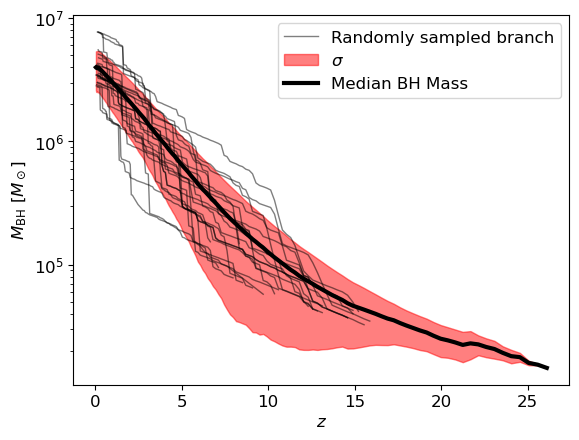

In [59]:
plt.rcParams.update({'font.size': 12})

plt.figure()
f=50
lw=1.0
alph=0.5
for x in range(int(1000.0/f)):
    if(x==0): plt.plot(z_list[x*f],bh_list[x*f],color="black", label="Randomly sampled branch",alpha=alph, lw=lw)
    plt.plot(z_list[x*f],bh_list[x*f],color="black",alpha=alph,lw=lw)

plt.fill_between(z, b-b_std, b+b_std,alpha=0.5,color="red",label=r"$\sigma$")
plt.plot(z,b,color="black", label="Median BH Mass", lw=3.0)

plt.legend()
plt.yscale("log")
plt.xlabel(r"$z$")
plt.ylabel(r"$M_{\rm BH} \ [M_\odot]$")
plt.savefig("figures/bh_vs_z.pdf", bbox_inches="tight")

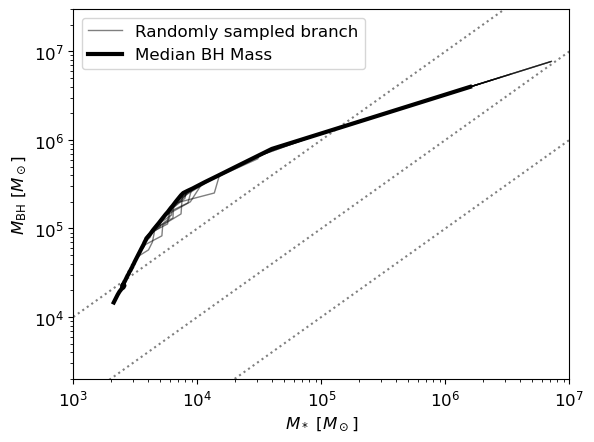

In [60]:
plt.figure()
plt.plot([1e3,1e8],[1e3,1e8],color="black",alpha = 0.5,ls=":")
plt.plot([1e3,1e8],[1e4,1e9],color="black",alpha = 0.5,ls=":")
plt.plot([1e3,1e8],[1e2,1e7],color="black",alpha = 0.5,ls=":")

#plt.errorbar(s,b,yerr=b_std)
#plt.fill_between(s, b-b_std, b+b_std,alpha=0.5,color="red",label=r"BH $\sigma$")
# plt.fill_betweenx(b, s-s_std, s+s_std,alpha=0.5,color="red",label=r"BH $\sigma$ vs Redshift")
#skip=5
##plt.errorbar(s[::skip],b[::skip],yerr=b_std[::skip], xerr=s_std[::skip],color="red",fmt='none',label=r"$\sigma$")
f=50
lw=1.0
alph=0.5
for x in range(int(1000.0/f)):
    if(x==0): plt.plot(sm_list[x*f],bh_list[x*f],color="black", label="Randomly sampled branch",alpha=alph, lw=lw)
    plt.plot(sm_list[x*f],bh_list[x*f],color="black",alpha=alph, lw=lw)
plt.plot(s,b,color="black", label="Median BH Mass", lw=3.0)

plt.xlim(1e3, 1e7)
plt.ylim(2e3,3e7)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$M_{\rm *} \ [M_\odot]$")
plt.ylabel(r"$M_{\rm BH} \ [M_\odot]$")
plt.savefig("figures/bh_vs_sm.pdf", bbox_inches="tight")

In [ ]:
#Behroozi 2019, the version we're going with
def calc_mass_beh_2019(m_h, z):
    m_h = get_peak(np.array(m_h))
    z   = np.array(z)
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.float_power(10, -alpha2(z)*x) + np.float_power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.float_power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    sm = np.float_power(10, log10_m_s)
    min_mass = 100
    sm[np.where(sm < min_mass)]= min_mass
    return sm

def evolve_BH(halo_mass, time, folding_time, fraction_cap, seed, cap_fraction = 1):  
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(halo_mass*OMEGA_B/OMEGA_M)

    if(seed == -1): bh_mass = [cap[0]*cap_fraction]
    else: bh_mass = [seed]

    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass



def calc_mass_wise(z,m_h):
    z=np.array(z)
    m_h = np.log10(m_h)
    
    #TEMP REMOVAL OF FILTER
#     mh_filter = np.where((m_h<=8.5))
#     m_h = m_h[mh_filter]

    m_vir_power = np.arange(6.5,8.6, 0.5)
    m_star_power = [3.41, 3.59,3.88,4.60,5.74]
    f =interpolate.interp1d(m_vir_power, m_star_power, kind='linear',fill_value='extrapolate')
    m_star = f(m_h)
    return np.power(10, m_star)
    #return z[mh_filter], np.power(10, m_h), np.power(10, m_star)



def calc_mass(m_h,z):
    m_star = calc_mass_wise(z,m_h)
    return m_star

    fraction =0.005
    #behroozi_mass_index_first = np.where((m_h >= 10**10.5) &(z<=10))[0][0]
#     print(m_h)
#     print(z)
    print("temporarily dropping beh max limit")
    behroozi_mass_index_first = np.where((m_h >= 10**8.7) &(z<=10))[0][0]
    z_wise, m_halo, m_star = calc_mass_wise(z,m_h)
    end=behroozi_mass_index_first
    stellar_mass = np.zeros(len(m_h))
    beh_mass = calc_mass_beh_2019(m_h[end:],z[end:])

    
    m0 = m_star[-1]
    mf = beh_mass[0]

    start=-1
    for x in range(len(m_star)):
        stellar_mass[x] = m_star[x]
        start+=1
    slope = (mf-m0)/(m_h[end] - m_h[start])
    for x in range(start,end,1):
        stellar_mass[x] = (m_h[x]-m_h[start])*slope + m0
    for x in range(end,len(m_h)):
        stellar_mass[x] = beh_mass[x-end]
    

    return stellar_mass


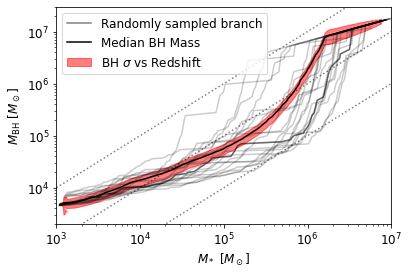

In [128]:
plt.figure()
plt.plot([1e3,1e8],[1e3,1e8],color="black",alpha = 0.5,ls=":")
plt.plot([1e3,1e8],[1e4,1e9],color="black",alpha = 0.5,ls=":")
plt.plot([1e3,1e8],[1e2,1e7],color="black",alpha = 0.5,ls=":")

#plt.errorbar(s,b,yerr=b_std)
plt.fill_between(s, b-b_std, b+b_std,alpha=0.5,color="red",label=r"BH $\sigma$ vs Redshift")
f=30
for x in range(20):
    if(x==0): plt.plot(sm_list[x*f],bh_list[x*f],color="black", label="Randomly sampled branch",alpha=0.5)
    plt.plot(sm_list[x*f],bh_list[x*f],color="black",alpha=0.2)
plt.plot(s,b,color="black", label="Median BH Mass")

plt.xlim(1e3, 1e7)
plt.ylim(2e3,3e7)
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$M_{\rm *} \ [M_\odot]$")
plt.ylabel(r"$M_{\rm BH} \ [M_\odot]$")
plt.savefig("figures/bh_vs_sm.pdf", bbox_inches="tight")

In [19]:
np.size(np.array(full_counts[2])[np.where(np.array(full_counts[2])>0)])

738

# Figure 2 leo hist

Redoing this section of the code, just using the leo candidacy files instead of searching through the trees

In [32]:

merger_ratio =[1.4, 1.4, 1.4]
merger_err = 0.075
temp_min = [9000, 7000, 5000]
temp_err = 1000
t_ratio = [1.0, 0.75, 0.5]
ratio_err = 0.1
full_counts = [[],[],[]]

all_files = list(glob.iglob("leo_candidacy_files/*"))
for f in all_files:
    df = pd.read_csv(f)
    mr, tt, mt, count_temp = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
    for x in range(3):
        a,b,c = merger_ratio[x], temp_min[x], t_ratio[x]
        filt = np.where((np.abs(mr - a) < merger_err) & (np.abs(tt - b) < temp_err) & (np.abs(mt - c) < ratio_err))
        #filt = np.where((np.abs(tt - b) < temp_err))
        full_counts[x].append(np.max(count_temp[filt]))

[7, 181, 965]


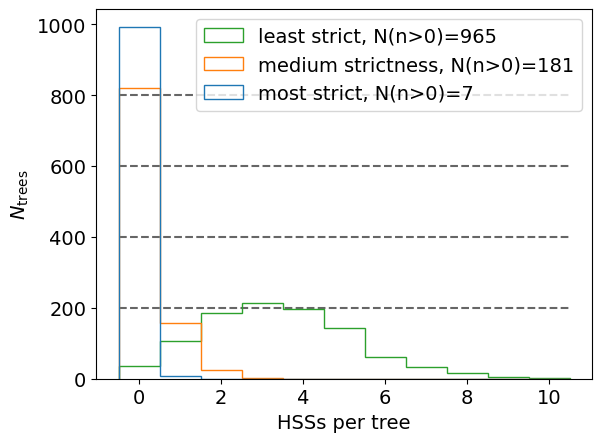

In [85]:
plt.figure()
maxN = np.max(full_counts)
shift=0.5
for y in np.arange(200,900,200):
    plt.plot(np.linspace(0-shift,maxN-shift,10), np.linspace(y,y,10),color="black", alpha=0.6,ls="--")

bins = np.arange(0,maxN+1, 1)
sizes = [np.size(np.where(np.array(full_counts[x])>0)) for x in range(3)]
print(sizes)
labels = ["most strict", "medium strictness", "least strict"]
labels = [labels[x]+ ", N(n>0)="+str(sizes[x]) for x in range(3)]
# for x in range(3):
#     plt.hist(full_counts[x],bins=bins-0.5, label=labels[x],alpha=0.8)#,rwidth=0.9)
plt.hist(full_counts,bins=bins-shift, label=labels,histtype="step")#,rwidth=0.9)

plt.ylabel(r"$N_{\rm trees}$")
plt.xlabel("HSSs per tree")
plt.legend(loc="upper right")
plt.savefig("figures/leo_hist.pdf",bbox_inches="tight")


# Figure 3 Tvir vs count

In [ ]:
# all_files = list(glob.iglob("leo_candidacy_files/*"))
# df = pd.read_csv(all_files[0])
# mr, tt, mt, count_temp = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
# unique_temps = np.sort(np.unique(tt))
# count_data = []
# count_mean = []
# for tcount,target_temp in enumerate(unique_temps):
#     print(target_temp)
#     target_counts_temp = []
#     for fcount,f in enumerate(all_files):
#         df = pd.read_csv(f)
#         mr, tt, mt, count_temp = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
#         target_counts_temp.append(count_temp[np.where(np.abs(tt-target_temp) < 0.01)])
#     count_data.append(np.percentile(target_counts_temp, [25,50,75]))
#     count_mean.append(np.mean(target_counts_temp))
# count_mean = np.array(count_mean)
# count_data = np.array(count_data).T
# print(count_data)

In [121]:
all_files = list(glob.iglob("leo_candidacy_files/*"))
df = pd.read_csv(all_files[0])
mr, tt, mt, count_temp = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
unique_temps = np.sort(np.unique(tt))
counts = np.empty((1000,20))

for fcount,f in enumerate(all_files):
    df = pd.read_csv(f)
    mr, tt, mt, count_temp = np.array(df["merger_ratio"]), np.array(df["target_temp"]), np.array(df["min_t_ratio"]), np.array(df["count"])
    for tcount,target_temp in enumerate(unique_temps):
        target_counts = count_temp[np.where(np.abs(tt-target_temp) < 0.01)]
        counts[fcount][tcount] = np.median(target_counts)
counts=counts.T


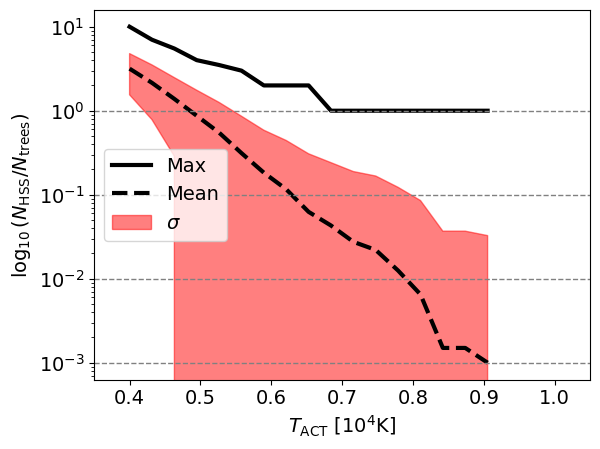

In [130]:
counts_max = np.max(counts, axis=1)
counts_mean = np.mean(counts, axis=1)
counts_std = np.std(counts, axis=1)
args = np.where(counts_max > 0)
plt.plot(unique_temps[args]/1e4, counts_max[args], color="black", lw=3,label="Max")

args = np.where(counts_mean > 0)
x,y,e = unique_temps[args]/1e4, counts_mean[args], counts_std[args]
plt.plot(unique_temps[args]/1e4, counts_mean[args], color="black", lw=3,label="Mean",ls="--")


plt.fill_between(x, y-e, y+e,alpha=0.5,color="red",label=r"$\sigma$")

tmin,tmax=0.35,1.05
for yval in [0.001, 0.01, 0.1, 1.0]:
    plt.plot(np.linspace(tmin,tmax,100), np.linspace(yval,yval,100),lw=1,ls="--",color="gray")
plt.yscale("log")
plt.xlim(tmin,tmax)
plt.xlabel(r"$T_{\rm ACT}$ [$10^4$K]")
plt.ylabel(r"$\log_{10}(N_{\rm HSS}/N_{\rm trees})$")
plt.legend()
plt.savefig("figures/count_vs_T.pdf", bbox_inches="tight")

# Everything below this is old

In [6]:
# def read_leo_files():
dcbh_files = np.sort(list(glob.iglob("leo_files/*.csv")))
print(np.size(dcbh_files))
counts = list(np.zeros(1000-np.size(dcbh_files)))
for f in dcbh_files:#range(Ntrees):

    ds =  pd.read_csv(f,delimiter=",",)#skiprows = 1, names=["more","blank","filler","ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10", "jlw"])

#     inds = np.array(ds["ind"])
    z = get_redshift("Snapshot_alist_mod")
    snaps = np.array(ds["snap_num"])
#     zs = np.array(z)[snaps]
#     mass = np.array(ds["mass/1e10"]*1e10)/0.7

#     prog_count = np.array(ds["prog_count"])
#     tvirs = T_vir(mass,zs)
    prog_count = np.array(ds["prog_count"])
    count = np.size(np.where(prog_count==0))
    counts.append(count)



996


In [11]:
ds =  pd.read_csv(f,delimiter=",",)
z = get_redshift("Snapshot_alist_mod")
snaps = np.array(ds["snap_num"])
zs = np.array(z)[snaps]
inds = np.array(ds["ind"])
times=z_to_time(zs)
desc = np.array(ds["desc"])
prog = np.array(ds["first_prog"])
prog_count = np.array(ds["prog_count"])
prog_inds = np.where(prog_count==0)
mass = np.array(ds["mass/1e10"]*1e10)/0.7
tvirs = T_vir(mass,zs)
count = np.size(np.where(prog_count==0))
print(count)

8


In [26]:
branch_ids = []
for x,current_prog in zip(range(len(prog)), prog):
    if any(current_prog in sub_branch for sub_branch in branch_ids):
        #print("HIT CONTINUE SECTION", current_prog)
        continue

    this_progs_ids = [inds[x]]
    prog_i = prog[x]

    while(True):
        index = np.where(inds == prog_i)[0]
        if(index.size == 0): break
        this_progs_ids.append(prog_i)

        prog_i = prog[index[0]]
    if(np.size(this_progs_ids)> 1):
        branch_ids.append(this_progs_ids)

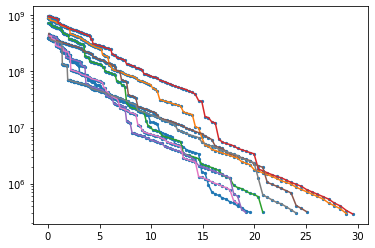

In [33]:
plt.figure()
plt.yscale("log")
for sub_branch in branch_ids:
    indices = []
    for ind in sub_branch:
        a=np.where(inds ==ind)[0][0]
        indices.append(a)
    branch_mass = mass[indices]
    branch_z = zs[indices]
    plt.plot(branch_z, branch_mass)
plt.scatter(zs,mass,s=5)


In [ ]:
MERGER_N = 20
TEMP_N = 20
TCOOL_N = 10
MERGER_RANGE = np.linspace(1.1, 2, MERGER_N)
TEMP_RANGE = [4e3, 7e3, 1e4] #np.linspace(4e3, 1e4, TEMP_N)
TCOOL_RANGE = np.linspace(0.05, 1.0, TCOOL_N)


for sub_branch in branch_ids:
    indices = []
    for ind in sub_branch:
        a=np.where(inds ==ind)[0][0]
        indices.append(a)
    branch_mass = mass[indices]
    branch_z = zs[indices]
    branch_tvirs = tvirs[indices]

    for target_temp in TEMP_RANGE:
        tvir_filter = np.where(branch_)

### I want to find the total count for a strict, medium, and least strict case. I'll rerun the filtering on these leo files

In [20]:



for x in range(MERGER_N):
            for z in range(TCOOL_N):
                grid_ind = get_grid_ind(x,y,z)
                merger_ratio, target_temp, min_t_ratio, count = grid[grid_ind]
                print("working on mr, tt, mt:", merger_ratio, target_temp, min_t_ratio)

                large_merger_count = 0
                for xi in range(len(branch_mass) -1):
                    if(branch_mass[xi] >= merger_ratio* branch_mass[xi+1]):
                        large_merger_count += 1
                lmc = large_merger_count
                if((lmc <= max_mergers) and (lmc > 0)):
                    #check the cooling times
                    #get all the progs
                    locations = []
                    locations.extend(get_all_progs(inds,prog, prog2, index_of_ach))
                    ach_t_ratio = t_ratio[locations]
                    if(np.all(ach_t_ratio > min_t_ratio)):
                        count += 1

                count_for_branch += count
                grid[grid_ind][-1] = count

array([ 934.80454121, 1311.1786461 ,  994.75692343, 1329.24491429,
        912.84824553, 1206.5078729 , 1119.18321637, 1116.53450267])

Text(0.5, 0, 'Number of Heavy Seed Leo-like Candidates per Tree')

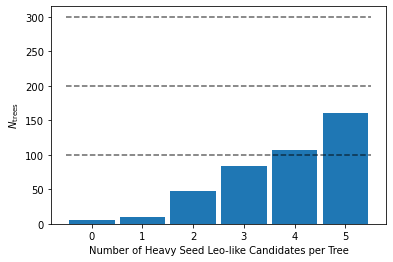

In [6]:
xrange =[0,1,2,3,4,5,6]
shift=0.5
N = 10
plt.hist(counts,bins=np.array(xrange)-shift,rwidth=0.9)
yrange = [100,200,300]
for y in yrange:
    plt.plot(np.linspace(np.min(xrange)-shift,np.max(xrange)-shift,N), np.linspace(y,y,N),color="black", alpha=0.6,ls="--")
plt.ylabel(r"$N_{\rm trees}$")
plt.xlabel("Number of Heavy Seed Leo-like Candidates per Tree")
#plt.savefig("figures/leo_hist.pdf",bbox_inches="tight")

# Leo Halo analysis (1st attempt)

In [5]:
def read_leo_trees(f):
    num_cands_list=[]
    Ntrees = 100
    total_lines = 191171140
    lines_per_tree = int(total_lines*1.0/Ntrees*1.2)
    start_index=1
    for n in range(Ntrees):
        
        print("reading tree ", n)
        ds =  pd.read_csv(f,delim_whitespace=True,skiprows = start_index,nrows = lines_per_tree, 
                          names=["ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10"])
        print("file read, organizing data")
        inds = np.array(ds["ind"])

        if(n < 99):
            end_tree = np.where(inds==0)[0][1]
            start_index += end_tree
            ds = ds.iloc[:end_tree,:]

        z = get_redshift("Snapshot_alist_mod")
        snaps = np.array(ds["snap_num"])
        zs = np.array(z)[snaps]
        mass = np.array(ds["mass/1e10"]*1e10)
        inds = np.array(ds["ind"])
        times=z_to_time(zs)
        desc = np.array(ds["desc"])
        prog = np.array(ds["first_prog"])
        #no_prog = np.where(prog == -1)[0]
        #prog[no_prog] = no_prog


        selection_filter = np.where((times >= (np.max(times)-tff.value)) & (mass < 2*mass_Leo.value) & (mass > 0.5*mass_Leo.value))
        np.size(selection_filter)


        filtered_mass = mass[selection_filter]
        filtered_progs = prog[selection_filter]
        filtered_inds = inds[selection_filter]


        branch_ids = []
        for x,current_prog in zip(range(len(filtered_progs)), filtered_progs):
            #print(current_prog, branch_ids)
            if any(current_prog in sub_branch for sub_branch in branch_ids): continue
            this_progs_ids = [filtered_inds[x]]
            prog_i = filtered_progs[x]
            #print(this_progs_ids, prog_i)
            while(prog_i!=-1):
                this_progs_ids.append(prog_i)
                #if(prog_i == prog[prog_i]): break
                prog_i = prog[prog_i]

            branch_ids.append(this_progs_ids)



        #find the number of leo candidates
        leo_candidate = []
        for sub_branch in branch_ids:
            branch_mass = mass[sub_branch]
            large_merger_count = 0
            for x in range(len(branch_mass) -1):
                if(branch_mass[x] >= 1.4* branch_mass[x+1]):
                    large_merger_count += 1
            if(large_merger_count == 1): leo_candidate.append(True)
            else: leo_candidate.append(False)
        num_cands = np.size(np.where(np.array(leo_candidate) == True))
        print("num_cands", num_cands)
        num_cands_list.append(num_cands)
    return num_cands_list

def get_redshift(file):
    f = open(file, "r")
    z=[]
    for line in f:
        a=float(line.strip("\n"))
        z.append(1/a - 1)
    return z

def z_to_time(z):
        a=2./(3.*np.sqrt(OMEGA_L))
        b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
        c = 71*1e5*3.154e+7/3.086e18
        return a/c*np.log(b+np.sqrt(1+b*b))

In [4]:
leo_trees = read_leo_trees("leo_history")

reading tree  0
file read, organizing data
num_cands 0
reading tree  1


KeyboardInterrupt: 

In [4]:
def time_to_z(t):
        z_range = np.linspace(0,51,100000)
        time_samples = z_to_time(z_range)
        z_indices = []
        for t0 in t: z_indices.append(np.argmin(np.abs(time_samples - t0)))
            
        return z_range[z_indices]

time_range = np.arange(0,13225,50)
z_range = time_to_z(time_range)
# for a in 1/(1+z_range):
#     print(a)

In [11]:
z_range = np.linspace(0,51,100000)
time_samples = z_to_time(z_range)
time_samples

array([13200.53348877, 13193.50780371, 13186.48734896, ...,
          44.220336  ,    44.21968545,    44.21903491])

In [ ]:
plt.hist(leo_trees, bins=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel("Number of Leo-Candidates per MW-like halo")
plt.ylabel("N")
plt.savefig("leo_candidates.pdf")

In [5]:
def z_to_time(z):
        a=2./(3.*np.sqrt(OMEGA_L))
        b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
        c = 71*1e5*3.154e+7/3.086e18
        return a/c*np.log(b+np.sqrt(1+b*b))
    
def time_to_z(t):
    t = a/c*np.log(b+np.sqrt(1+b*b))
    a=2./(3.*np.sqrt(OMEGA_L))
        b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
        c = 71*1e5*3.154e+7/3.086e18
    b+np.sqrt(1+b*b) = np.exp(t*a/c)

IndentationError: unexpected indent (Temp/ipykernel_2300/1117674216.py, line 10)

In [15]:
def calc_tff(z, m1,m2=0): #kpc, msun, msun
    r = r_vir(m1, z)*u.kpc
    m1 = m1*u.Msun
    m2 = m2*u.Msun
    return (np.pi/2.0 * (np.power(r,1.5)/np.sqrt(2*G*(m1 +m2)))).to("Myr")

def r_vir(m_h,z):
    #returns kpc
    h=0.7
    
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1
    delta_c = 18*np.pi*np.pi + 82*d -39*d*d

    return 0.784/h* np.float_power(m_h*h/1e8, 1.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * (delta_c/(18*np.pi*np.pi)), -1.0/3) * (10/(1+z))



print(calc_tff(20, 1e7,1))


0.1221484291941361
30.797844503208616 Myr


In [5]:

# r_leo = 250*u.kpc #kpc
# mass_MW = 1e12*u.Msun
# mass_Leo = 6e7*u.Msun

tff = np.pi/2.0 * (np.power(r_leo,1.5)/np.sqrt(2*G*(mass_MW +mass_Leo)))
tff = tff.to("Myr")
tff

<Quantity 2063.86808632 Myr>

# 2nd attempt at leo dcbhs 

In [3]:
r_leo = 250*u.kpc #kpc
mass_MW = 1e12*u.Msun
mass_Leo = 1e8*u.Msun
mass_tolerance = 6
mt = mass_tolerance

tff = np.pi/2.0 * (np.power(r_leo,1.5)/np.sqrt(2*G*(mass_MW +mass_Leo)))
tff = tff.to("Myr")


def T_vir(m,z):
    h=0.7 
    
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    return 1.98e4*(u/0.6)*np.float_power(m*h/1e8, 2.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0


def T_vir_inverted(T,z):
    h=0.7
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    m = np.float_power(T/(1.98e4*(u/0.6)) / (np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0),3.0/2)*1e8/h
    return m


def read_leo_dcbhs():
    num_cands_list=[]
    plt.figure()
    dcbh_files = np.sort(list(glob.iglob("dcbh_files/dcbh_files/*.csv")))
    inds_keep = []
    for f in dcbh_files:#range(Ntrees):

        ds =  pd.read_csv(f,delimiter=",",skiprows = 1, names=["filler","ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10", "jlw"])

        inds = np.array(ds["ind"])
        z = get_redshift("Snapshot_alist_mod")
        snaps = np.array(ds["snap_num"])
        zs = np.array(z)[snaps]
        mass = np.array(ds["mass/1e10"]*1e10)/0.7
        inds = np.array(ds["ind"])
        times=z_to_time(zs)
        desc = np.array(ds["desc"])
        prog = np.array(ds["first_prog"])
        tvirs = T_vir(mass,zs)

        selection_filter = np.where((times >= (np.max(times)-tff.value)) & (mass <= mt*mass_Leo.value) & (mass >= 1.0/mt*mass_Leo.value))
        iltered_mass = mass[selection_filter]
        filtered_progs = prog[selection_filter]
        filtered_inds = inds[selection_filter]
        #num_cands_list.append(np.size(selection_filter))
#         plt.scatter(times, mass, s=10)
        if(np.size(selection_filter) == 0): continue
            
        #remove duplicate candidates (different snaps of the same halo)    
        branch_ids = []
        for x,current_prog in zip(range(len(filtered_progs)), filtered_progs):

            if any(current_prog in sub_branch for sub_branch in branch_ids): continue
            this_progs_ids = [filtered_inds[x]]
            prog_i = filtered_progs[x]

            while(True):
                index = np.where(inds == prog_i)[0]
                if(index.size == 0): break
                this_progs_ids.append(prog_i)

                prog_i = prog[index[0]]

            branch_ids.append(this_progs_ids)



        #find the number of leo candidates
        leo_candidate = []
        for sub_branch in branch_ids:
            indices = []
            for ind in sub_branch:
                a=np.where(inds ==ind)[0][0]
#                 if(a.size==0): break
#                 print(zs[a])
#                 print(tvirs[a]/1e4)
#                 print(ind, np.where(inds ==ind)[0])
#                 print
                indices.append(np.where(inds ==ind)[0][0])
            branch_mass = mass[indices]
            branch_z = zs[indices]
#             print(branch_mass)
#             print(branch_z)
#             print("TEMP CHECK\n\n\n", T_vir(branch_mass[-1],branch_z[-1])/1e4)
            large_merger_count = 0
            plt.plot(branch_z, branch_mass)
            plt.yscale("log")
            for x in range(len(branch_mass) -1):
                if(branch_mass[x] >= 1.4* branch_mass[x+1]):
                    large_merger_count += 1
            if(large_merger_count == 1): leo_candidate.append(True)
            else: leo_candidate.append(False)
        num_cands = np.size(np.where(np.array(leo_candidate) == True))
        print("num_cands", num_cands)
        num_cands_list.append(num_cands)
        
        
#     Np = 1000
#     mr = np.linspace(1.0/mt*mass_Leo.value,mt*mass_Leo.value, Np)
#     tr = np.linspace(13200.533488773533-tff.value,13200.533488773533,Np)
#     plt.plot(np.linspace(np.min(tr), np.min(tr), Np), mr, color="black")
#     plt.plot(np.linspace(np.max(tr), np.max(tr), Np), mr, color="black")
#     plt.plot(tr, np.linspace(np.min(mr), np.min(mr), Np), color="black")
#     plt.plot(tr, np.linspace(np.max(mr), np.max(mr), Np), color="black", label="leo candidate")
#     plt.yscale("log")
#     plt.legend()
#     plt.xlabel("time [myr]")
#     plt.ylabel("mass [msun]")
#     plt.savefig("dcbh_leo_cands.pdf")
    
    return num_cands_list, inds_keep

num_cands, cand_inds = read_leo_dcbhs()

<Figure size 432x288 with 0 Axes>

In [6]:
T_vir(1e7, 10)

5075.864049244572

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

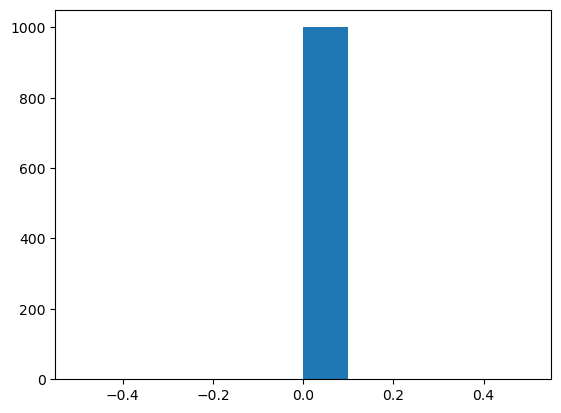

In [31]:
plt.hist(num_cands)

In [48]:
ds =  pd.read_csv("trees/tree_0",delimiter=" ",skiprows = 1, names=["ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10"])
#print("file read, finding leo candidates")
inds = np.array(ds["ind"])
z = get_redshift("Snapshot_alist_mod")
snaps = np.array(ds["snap_num"])
zs = np.array(z)[snaps]
mass = np.array(ds["mass/1e10"]*1e10)
inds = np.array(ds["ind"])
times=z_to_time(zs)
desc = np.array(ds["desc"])
prog = np.array(ds["first_prog"])
#         print(times[0])
#         print(mass[0])
#         print(zs)

In [22]:


T = 1e4
z_range = np.linspace(0,50, 1000)
Ms = T_vir_inverted(T,z_range)

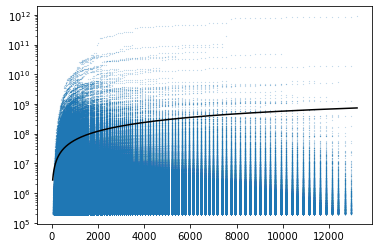

In [61]:
plt.scatter(times, mass, s=0.01)
plt.plot(z_to_time(z_range), Ms,color="black")
plt.yscale("log")

In [52]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure()
using_mpl_scatter_density(fig, times,mass)
plt.show()

ModuleNotFoundError: No module named 'mpl_scatter_density'

# Functions

In [36]:
#J1 from https://arxiv.org/pdf/1806.07893.pdf. I'm not sure if it's safe to say M_peak = M_halo
#valid for M_halo 10^10 - 10^15 M_sol and z 0-10
#1/30/2022, updating the values for the row: TRUE, SF, ALL, EXCL

E0 = -1.494
Ea = 1.569
Elna = 1.293
Ez = -0.215
M0 = 12.059
Ma = 4.645
Mlna = 4.544
Mz = -0.757
A0 = 1.905
Aa = -2.555
Alna = -1.875
Az = 0.197
B0 = 0.509
Ba = -0.889
Bz = -0.538
D0 = 0.460
Y0 = -0.807
Ya = -1.859
Yz = -0.637
Msol = 1.989e30

def a(z0):
    return 1/(1+z0)

def log10_m_2(z0):
    return M0 + Ma*(a(z0)-1) - Mlna*np.log(a(z0)) + Mz*z0 #+math.log10(Msol)

def epsilon2(z0):
    return E0 + Ea*(a(z0)-1) - Elna*np.log(a(z0)) + Ez*z0

def alpha2(z0):
    return A0 + Aa*(a(z0)-1) - Alna*np.log(a(z0)) + Az*z0

def beta2(z0):
    return B0 + Ba*(a(z0)-1) + Bz*z0

def delta2(z0):
    return D0

def gamma2(z0):
    return 10**(Y0 + Ya*(a(z0)-1) + Yz*z0) 


def get_peak(mass):
    peak = 0
    for x in range(len(mass)):
        if(mass[x] < peak): mass[x] = peak
        else: peak = mass[x]
    return mass


#Behroozi 2019, the version we're going with
def calc_mass_beh_2019(m_h, z):
    m_h = get_peak(np.array(m_h))
    z   = np.array(z)
    z_max,z_min = np.max(z), np.min(z)
    if(z_max != z_min):
        z_factor = (z_max - z)/(z_max - z_min)
    else: z_factor = 1
    
    z = z_factor * Z_SCALE*z
        
#     z_mod = np.where(z<Z_SWITCH)
#     z[z_mod] = Z_NEW
    x = np.log10(m_h) - log10_m_2(z)
    a = -np.log10(np.float_power(10, -alpha2(z)*x) + np.float_power(10,-beta2(z)*x))
    b = gamma2(z)*np.exp(-0.5*np.float_power(x,2)/(delta2(z)**2))
    log10_m_s = epsilon2(z) + log10_m_2(z) + a + b
    sm = np.float_power(10, log10_m_s)
    min_mass = 100
    sm[np.where(sm < min_mass)]= min_mass
    return sm

def calc_mass_wise(z,m_h):
    z=np.array(z)
    m_h = np.log10(m_h)
    
    mh_filter = np.where((m_h<=8.5))
    m_h = m_h[mh_filter]

    m_vir_power = np.arange(6.5,8.6, 0.5)
    m_star_power = [3.41, 3.59,3.88,4.60,5.74]
    f =interpolate.interp1d(m_vir_power, m_star_power, kind='linear',fill_value='extrapolate')
    m_star = f(m_h)
    return z[mh_filter], np.power(10, m_h), np.power(10, m_star)

def calc_mass(m_h,z):
    try:
        behroozi_mass_index_first = np.where((m_h >= 10**10.5) &(z<=10))[0][0]
        end=behroozi_mass_index_first
    except:
        end=len(m_h)-1

    z_wise, m_halo, m_star = calc_mass_wise(z,m_h)
    stellar_mass = np.zeros(len(m_h))
    beh_mass = calc_mass_beh_2019(m_h[end:],z[end:])
#     print(beh_mass)

    
    m0 = m_star[-1]
    mf = beh_mass[0]

    start=-1
    for x in range(len(m_star)):
        stellar_mass[x] = m_star[x]
        start+=1
    slope = (mf-m0)/(m_h[end] - m_h[start])
    for x in range(start,end,1):
        stellar_mass[x] = (m_h[x]-m_h[start])*slope + m0
    for x in range(end,len(m_h)):
        stellar_mass[x] = beh_mass[x-end]
    

    return stellar_mass




def evolve_BH(halo_mass, time, folding_time, fraction_cap, seed, cap_fraction = 1):  
    dt = np.array(time[1:len(time)])-np.array(time[0:len(time)-1])
    scale_factor = np.exp(dt/folding_time)
    cap =fraction_cap*np.array(halo_mass*OMEGA_B/OMEGA_M)

    if(seed == -1): bh_mass = [cap[0]*cap_fraction]
    else: bh_mass = [seed]

    for i,sf in enumerate(scale_factor):
        old_mass = bh_mass[i]
        growth = old_mass*sf
        c = cap[i+1]

        if(growth <= c): 
            bh_mass.append(growth)
        elif(c>old_mass):
            bh_mass.append(c)
        else: 
            bh_mass.append(old_mass) #this occurs when the cap shrinks due to stripping
            
    return bh_mass

def create_tree_df(tree):
    names = ["z", "time", "mass", "t_vir", "stellar_mass", "j_mean", "j_ratio", "j_lw", "ind", "desc"]
    z,m = tree[0], tree[1]
    jmean, jr, jlw = tree[2], tree[3], tree[4]
    ind, desc = tree[5], tree[6]
    t_vir = T_vir(m,z)
    time = z_to_time(z)
    sm = calc_mass(m,z)    
#         sm = sm1#np.maximum(sm1,sm2)

    data = np.array([z,time,m,t_vir,sm,jmean, jr, jlw, ind, desc]).T
    data = np.array(data)
    df = pd.DataFrame(data,columns = names)
    
    
    
    return df


def T_vir(m,z):
    h=0.7 
    
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    return 1.98e4*(u/0.6)*np.float_power(m*h/1e8, 2.0/3)*np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0


def T_vir_inverted(T,z):
    h=0.7
    u = 1.22
    #eq 26 from https://arxiv.org/pdf/astro-ph/0010468.pdf
    #returns virial temp in units of Kelvin
    OMEGA_K = 1-OMEGA_M-OMEGA_L
    OMEGA_M_Z=OMEGA_M*np.float_power(1+z,3)/ (OMEGA_M*np.float_power(1+z,3) + OMEGA_L + OMEGA_K*np.float_power(1+z,2))
    d = OMEGA_M_Z-1

    delta_c = 18*np.pi*np.pi + 82*d -39*d*d
    m = np.float_power(T/(1.98e4*(u/0.6)) / (np.float_power(OMEGA_M/OMEGA_M_Z * delta_c/(18*np.pi*np.pi),1.0/3) *(1+z)/10.0),3.0/2)*1e8/h
    return m


def z_to_time(z):
        a=2./(3.*np.sqrt(OMEGA_L))
        b = np.sqrt(OMEGA_L/OMEGA_M)*np.float_power(1+z, -1.5)
        c = 71*1e5*3.154e+7/3.086e18
        return a/c*np.log(b+np.sqrt(1+b*b))


def get_tree_num(f):
    return int(str(f.split("tree_")[-1]).split("_")[0])

def get_chunk_num(f):
    return int((f.split("chunk_")[-1]).split("_in")[0])

def get_all_branches(path=-1):
    if(path == -1):
        all_cand_files = np.sort(glob.glob("dcbh_files/*.csv"))
    else:
        all_cand_files = np.sort(glob.glob(path+"/*.csv"))

#     print(all_cand_files[0])
    tree_nums = [get_tree_num(f) for f in all_cand_files]

#     tree_nums = [int(str(f.split("tree")[-1]).split("\\")[0]) for f in all_cand_files]
    chunk_nums = [get_chunk_num(f) for f in all_cand_files]
    ids = [250*tn + cn for tn,cn in zip(tree_nums, chunk_nums)]
    all_cand_files = all_cand_files[np.argsort(ids)]
    all_trees_raw = []
    num_dcbhs = []

    all_trees = []
    tree_ids = []
    tree_num = -1
    for f in all_cand_files:



#         current_num = int(str(f.split("tree")[-1]).split("\\")[0])
        current_num = get_tree_num(f)
        chunk_num = get_chunk_num(f)
        if(current_num != tree_num):
            tree_num = current_num
            print("working on tree", tree_num)

        ds =  pd.read_csv(f)
        if(len(ds) == 0): continue
        desc = np.array(ds["desc"])
        inds = np.array(ds["ind"])
        mass = np.array(ds["mass/1e10"])*1e10
        z = get_redshift("Snapshot_alist_mod")
        snaps = np.array(ds["snap_num"])
        mean_jlw = np.array(ds["mean_jlw"])
        j_ratios = np.array(ds["j_ratios"])
        j_lw = np.array(ds["j_lw"])
        zs = np.array(z)[snaps]

        all_trees_raw.append(np.array([zs, z_to_time(zs), mass,inds, desc]))


        dcbh_starts = np.setdiff1d(inds, desc)
        num_dcbhs.append(len(dcbh_starts))

        index = [np.where(inds == start)[0][0] for start in dcbh_starts]
        max_ir = np.argsort(j_lw[index])[-BRANCH_PER_TREE:]
        dcbh_starts = (inds[index])[max_ir]

        all_branches = []
        for start in dcbh_starts:
            index = np.where(inds == start)[0]
            if(len(index)>1):print("ERROR")
            index = index[0]
            #print(index)
            mass_list, z_list = [],[]
            ind_values, desc_values = [],[]
            jmean, jr,jlw = [],[],[]
            desc_id = np.where(inds == desc[index])[0][0]
            count = 0
            while(True):
                mass_list.append(mass[index])
                z_list.append(zs[index])
                jmean.append(mean_jlw[index])
                jr.append(j_ratios[index])
                jlw.append(j_lw[index])
                ind_values.append(inds[index])
                desc_values.append(desc[index])
                #if(count ==0): print(mass_list[0], z_list[0])
                index = desc_id
                desc_id = np.where(inds == desc[index])[0]
                if(len(desc_id) == 0): 
                    z_list.append(zs[0])
                    mass_list.append(mass[0])
                    jmean.append(mean_jlw[0])
                    jr.append(j_ratios[0])
                    jlw.append(j_lw[0])
                    ind_values.append(inds[0])
                    desc_values.append(desc[0])
                    break
                if(len(desc_id) > 1): print("ERROR")
                desc_id = desc_id[0] 
                count+=1
            all_branches.append(np.array([np.array(z_list), np.array(mass_list), 
                                          np.array(jmean), np.array(jr), np.array(jlw), 
                                          ind_values, desc_values]))
            tree_ids.append(100*int(tree_num)+int(chunk_num))
        for t in all_branches: all_trees.append(create_tree_df(t))
    tree_ids = np.array(tree_ids)
    return tree_ids, all_trees

def get_all_trees(tree_ids, all_branches,ft,cap,optimstic,keep_all,full=True,seed=-1, cap_fraction=1.0):
    
    all_trees = []
    for tree_id in np.sort(np.unique(tree_ids)):
        #if(tree_id!=94):continue
        branches = [all_branches[i] for i in np.sort(np.where(tree_ids == tree_id)[0])]

        if(not optimstic):
            all_init_j_lw = [branch["j_lw"][0] for branch in branches]
            tree = branches[np.argmax(all_init_j_lw)]
            tree = tree.drop(['j_mean',	'j_ratio',	'ind',	'desc'], axis=1)
            tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed, cap_fraction = cap_fraction)
            all_trees.append(tree)
 
        else:
            all_z, all_inds, all_bh, all_m, all_sm, all_bh,all_t, all_jlw= [],[],[],[],[],[],[],[]


            for branch in branches:
                all_z.append(np.array(branch["z"]))
                all_t.append(z_to_time(np.array(branch["z"])))
                all_inds.append(np.array(branch["ind"]))
                all_sm.append(np.array(branch["stellar_mass"]))
                all_m.append(np.array(branch["mass"]))
                all_jlw.append(np.array(branch["j_lw"]))
                all_bh.append(np.zeros(len(np.array(branch["mass"]))))


            
            m_all_z, m_all_inds, m_all_bh, m_all_m, m_all_sm,m_all_t, m_all_jlw= [],[],[],[],[],[],[]
            total_steps_index = np.argmax([len(zlist) for zlist in all_z])
            total_z = all_z[total_steps_index]
            total_steps = len(total_z)
            for step in range(total_steps):

                indices_for_branch = []
                z_step = total_z[step]

                for z_list in all_z:
                    if(z_step in z_list): indices_for_branch.append(np.where(z_list ==z_step)[0][0])
                    else: indices_for_branch.append(-1)

                current_inds = []
                #print(z_step, indices_for_branch)
                for x in range(len(indices_for_branch)):
                    branch_index = indices_for_branch[x]
                    if(branch_index == -1): 
                        if(-1 not in current_inds): current_inds.append(-1)
                        else: current_inds.append(min(current_inds) - 1)
                        continue
                    else:
                        #seeding or growing BHs
                        if(branch_index == 0): 
                            if(seed==-1):all_bh[x][0] = (cap*OMEGA_B/OMEGA_M)*all_m[x][0]
                            else: all_bh[x][0] = seed
                        else: 
                            i2,i1 = branch_index, branch_index-1
                            m,t = all_m[x][i1:i2+1],all_t[x][i1:i2+1]
                            all_bh[x][i2] = evolve_BH(m, t, ft, cap, all_bh[x][i1], cap_fraction = cap_fraction)[-1]              
         
                        current_inds.append(all_inds[x][branch_index])
                
                if(len(current_inds) != len(np.unique(current_inds))):
                    #print("current inds:", current_inds)
                    unq, unq_idx, unq_cnt = np.unique(current_inds, return_inverse=True, return_counts=True)
                    merger_indx = np.where(unq[np.argmax(unq_cnt)] == np.array(current_inds))[0]

                    indx_list = []
                    i1,i2 = merger_indx[0],merger_indx[1]
                    bh_list = [all_bh[i][indices_for_branch[i]] for i in merger_indx]
                    z_init_list = [all_z[i][0] for i in merger_indx]
                    j_init_list = [all_jlw[i][0] for i in merger_indx]
                    #print("bh_list=",bh_list)
                    total_mass = np.max(bh_list)
                    #keep = merger_indx[np.argmax(bh_list)]
                    keep = merger_indx[np.argmax(z_init_list)]
                    #for i in merger_indx: all_bh[i][indices_for_branch[i]] = 0
                    all_bh[keep][indices_for_branch[keep]] = total_mass
                    
                    #translate from merger index to global index
                    
                    for i in np.sort(merger_indx)[::-1]:
                        if(i==keep): continue
                        #print(i)
                        if(full):
                            m_all_z.append(all_z[i])    
                            m_all_inds.append(all_inds[i])    
                            m_all_m.append(all_m[i])    
                            m_all_sm.append(all_sm[i])    
                            m_all_t.append(all_t[i])    
                            m_all_bh.append(all_bh[i])    
                            m_all_jlw.append(all_jlw[i])    
                        else: 
                            m_all_z.append(all_z[i][:indices_for_branch[i]+1])    
                            m_all_inds.append(all_inds[i][:indices_for_branch[i]+1])    
                            m_all_m.append(all_m[i][:indices_for_branch[i]+1])    
                            m_all_sm.append(all_sm[i][:indices_for_branch[i]+1])    
                            m_all_t.append(all_t[i][:indices_for_branch[i]+1])    
                            m_all_bh.append(all_bh[i][:indices_for_branch[i]+1])
                            m_all_jlw.append(all_jlw[i][:indices_for_branch[i]+1])
                        del all_z[i]
                        del all_t[i]
                        del all_inds[i]
                        del all_sm[i]
                        del all_m[i]
                        del all_jlw[i]
                        del all_bh[i]
            if(full): 
                all_indices = list(all_inds[0])
                all_bh_masses_for_indices = list(all_bh[0])
                for x in range(len(m_all_bh)):
                    pre_merger_indices = np.where(m_all_bh[x] != 0)[0]
                    all_indices.extend(np.array(m_all_inds[x])[pre_merger_indices])
                    all_bh_masses_for_indices.extend(np.array(m_all_bh[x])[pre_merger_indices])

                for x in range(len(m_all_bh)):
                    post_merger_indices = np.where(m_all_bh[x] == 0)[0]
                    for y in post_merger_indices:
                        ind = m_all_inds[x][y]
                        if(ind in all_indices):
                            merged_mass = all_bh_masses_for_indices[np.where(np.array(all_indices) == ind)[0][0]]
                            m_all_bh[x][y] = merged_mass
                        else: print("ERROR", tree_id,x)
                    
                
 
            
            
            names = ["z", "time", "mass", "t_vir", "stellar_mass", "bh_mass","inds", "j_lw"]
            z,time,m = all_z[0],all_t[0], all_m[0]
            t_vir = T_vir(m,z)
            sm = all_sm[0]
            bhm = all_bh[0]
            inds = all_inds[0]
            jlw = all_jlw[0]
            data = np.array([z,time,m,t_vir,sm,bhm,inds, jlw]).T
            data = np.array(data)
            df = pd.DataFrame(data,columns = names)
            all_trees.append(df)
            if(keep_all):
                for x in range(len(m_all_m)):
                    z,time,m = m_all_z[x],m_all_t[x], m_all_m[x]
                    t_vir = T_vir(m,z)
                    sm = m_all_sm[x]
                    bhm = m_all_bh[x]
                    inds = m_all_inds[x]
                    jlw = m_all_jlw[x]
                    data = np.array([z,time,m,t_vir,sm,bhm,inds, jlw]).T
                    data = np.array(data)
                    df = pd.DataFrame(data,columns = names)
                    all_trees.append(df)    


            
            

    
    return all_trees



def get_redshift(file):
    f = open(file, "r")
    z=[]
    for line in f:
        a=float(line.strip("\n"))
        z.append(1/a - 1)
    return z

def create_tree_df_simple(tree):
    names = ["z", "time", "mass", "t_vir", "stellar_mass"]
    z,m = tree[0], tree[1]
    t_vir = T_vir(m,z)
    time = z_to_time(z)
    sm = calc_mass(m,z)    
    data = np.array([z,time,m,t_vir,sm]).T
    data = np.array(data)
    df = pd.DataFrame(data,columns = names)
    
    return df


def read_filtered_trees(ft, cap,seed):
    all_tree_files = glob.glob("filtered_trees/*")
    all_trees=[]
    for f in all_tree_files: 
        tree = pd.read_csv(f)
        tree = tree[tree["z"] < 25]
        tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
        all_trees.append(tree)
        
        
    return all_trees
def find_averages(all_trees,median=False):
    
    all_bh_mass = np.array([list(t["bh_mass"]) for t in all_trees])
    all_sm = np.array([list(t["stellar_mass"]) for t in all_trees])
    lengths = np.array([np.size(b) for b in all_bh_mass])
    bh_avs, bh_std = [], []
    sm_avs, sm_std = [], []
    for x in range(np.max(lengths)):
        filter_ = np.where(x<lengths)[0]
        bh_temp = all_bh_mass[filter_]
        sm_temp = all_sm[filter_]
        bhs = [bh_temp_it[x] for bh_temp_it in bh_temp]
        if(median): bh_avs.append(np.median(bhs))
        else: bh_avs.append(np.mean(bhs))
        bh_std.append(np.std(bhs))
        sms = [sm_temp_it[x] for sm_temp_it in sm_temp]
        if(median): sm_avs.append(np.median(sms))
        else: sm_avs.append(np.mean(sms))
        sm_std.append(np.std(sms))
    bh_avs,bh_std, sm_avs, sm_std = np.array(bh_avs), np.array(bh_std), np.array(sm_avs), np.array(sm_std)
    z_av,time_av = np.array(all_trees[np.argmax(lengths)]["z"]), np.array(all_trees[np.argmax(lengths)]["time"])
    return z_av,bh_avs,bh_std, sm_avs, sm_std


def find_min_max_bh(all_trees):
    final_bh_mass = np.array([list(t["bh_mass"])[-1] for t in all_trees])
    smallest_arg, largest_arg = np.argmin(final_bh_mass), np.argmax(final_bh_mass)

    least_massive_sm = np.array(all_trees[smallest_arg]["stellar_mass"])
    least_massive_bh = np.array(all_trees[smallest_arg]["bh_mass"])
    most_massive_sm  = np.array(all_trees[largest_arg]["stellar_mass"])
    most_massive_bh  = np.array(all_trees[largest_arg]["bh_mass"])
    return least_massive_sm, least_massive_bh, most_massive_sm, most_massive_bh



def grow_heavy_seeds(branches,ft, cap,seed):
    all_trees=[]
    for b in branches: 
        tree = b[b["z"] < 25]
        tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
        all_trees.append(tree)
    return all_trees


# Setting up the HMF which will determine the final mass of our trees at z=5

In [11]:
m_h = np.logspace(7,12.5, 400)
z = np.linspace(5,5, len(m_h))
m_star = calc_mass(m_h, z)
log_m_star = np.log10(m_star)
low, up =  7.8, 10.2

args = np.where((log_m_star >= low) & (log_m_star <= up))
low_mh, up_mh = np.min(m_h[args]), np.max(m_h[args])
low_mh, up_mh = np.min(m_h[args]), np.max(m_h[args])

mf = MassFunction()
mf.z=10

In [12]:
# plt.plot(mf.k, mf.power, label="normed")
# plt.plot(mf.k, mf._unnormalised_power, label="no norm")
# plt.legend()
# plt.yscale("log")
# plt.xscale("log")

In [13]:
dndm = mf.dndm
m = mf.m
args_hm = np.where((m>= low_mh) & (m <= up_mh))


dms = m_filt[1:] - m_filt[:-1]
dn = dndm_filt[:-1]*dms

cumsum = np.cumsum(dn)
# plt.plot(m_filt[:-1], cumsum)
# plt.yscale("log")
# plt.xscale("log")


NameError: name 'm_filt' is not defined

In [120]:
N_trees = int(1e4)
rans = np.random.uniform(low=np.min(cumsum), high=np.max(cumsum),size=N_trees)
m_h_target =interpolate.interp1d(cumsum, m_filt[:-1], kind='cubic',fill_value='extrapolate')(rans)

array([6.73546301e+10, 5.65167077e+10, 1.31356285e+11, ...,
       4.50176082e+10, 8.32667523e+10, 6.92829599e+10])

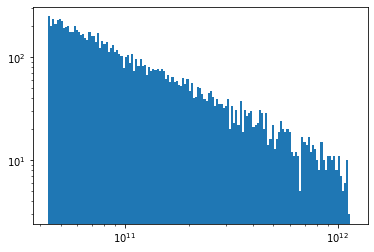

In [122]:
plt.hist(m_h_target, bins=m_filt)
plt.yscale("log")
plt.xscale("log")

# Now with the target halo masses, send this to the catalog.txt file(s) for the MC tree code

In [123]:
print(np.max(m_h_target)/1e12)
print(np.min(m_h_target)/1e10)

1.1447265371849404
4.365189214538868


In [ ]:
N_per_file = 250
working_dir = "trees_for_j"
N_files = int(N_trees/N_per_file)
catalog_base = "catalog_base.txt"
for x in range(N_files):
    number = str(x)
    with io.open(working_dir+"/"+catalog_base, "r", newline='\n') as fin:
        with io.open(working_dir+"/catalog"+number+".txt", "w", newline='\n') as fout:
            for line in fin:
                if("mass" not in line):
                    fout.write((line.replace('N', number)).replace('\r', ''))
            #print(list(fout))
            mhs = m_h_target[x*N_per_file:(x+1)*N_per_file]
            for i in range(len(mhs)):
                newline = "{:e}".format(mhs[i])+"   0  " + number + "\n"
                fout.write(newline.replace('\r', ''))
    fin.close()
    fout.close()
    
    with io.open(working_dir+"/skx_base", "r", newline='\n') as fin:
        with io.open(working_dir+"/skx"+number, "w", newline='\n') as fout:
            for line in fin:
                fout.write((line.replace('NUMBER', number)).replace('\r', ''))

    with io.open(working_dir+"/skx_find_base", "r", newline='\n') as fin:
        with io.open(working_dir+"/skx_find"+number, "w", newline='\n') as fout:
            for line in fin:
                fout.write((line.replace('NUMBER', number)).replace('\r', ''))




    fin.close()
    fout.close()
    
with io.open(working_dir+"/submit_jobs_find.sh", "w", newline='\n') as fout:
    fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
    for x in range(N_files):
        
        fout.write(("sbatch skx_find"+str(x)+"\n\n").replace('\r', ''))
    fout.close()

with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
    fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
    for x in range(N_files):
        
        fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
    fout.close()

with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
    fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
    for x in range(N_files):
        
        fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
    fout.close()

# Grow the trees (code for junyao's project)

In [49]:
all_tree_files = glob.glob("trees/*")
print(all_tree_files)
f=all_tree_files[0]
ds =  pd.read_csv(f,delim_whitespace=True,skiprows=1,names=["ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10"])

['trees\\batch_0', 'trees\\batch_1', 'trees\\batch_10', 'trees\\batch_11', 'trees\\batch_12', 'trees\\batch_13', 'trees\\batch_14', 'trees\\batch_15', 'trees\\batch_16', 'trees\\batch_17', 'trees\\batch_18', 'trees\\batch_19', 'trees\\batch_2', 'trees\\batch_20', 'trees\\batch_21', 'trees\\batch_22', 'trees\\batch_23', 'trees\\batch_24', 'trees\\batch_25', 'trees\\batch_26', 'trees\\batch_27', 'trees\\batch_28', 'trees\\batch_29', 'trees\\batch_3', 'trees\\batch_30', 'trees\\batch_31', 'trees\\batch_32', 'trees\\batch_33', 'trees\\batch_34', 'trees\\batch_35', 'trees\\batch_36', 'trees\\batch_37', 'trees\\batch_38', 'trees\\batch_39', 'trees\\batch_4', 'trees\\batch_5', 'trees\\batch_6', 'trees\\batch_7', 'trees\\batch_8', 'trees\\batch_9']


### randomly select a branch from each tree which will host our light seed 

In [5]:
# total_files = 40
# trees_per_file = 250

# all_tree_files = glob.glob("trees/*")
# all_trees = []



# for tree_num in range(total_files):
#     print("starting tree ", tree_num)
#     print(all_tree_files[tree_num])
#     ds =  pd.read_csv(all_tree_files[tree_num],delim_whitespace=True,skiprows=1,names=["ind","snap_num","desc","prog_count","first_prog","next_prog","mass/1e10"])
    
#     inds = np.array(ds["ind"])
#     ends = np.where(inds ==0)[0]
#     z_list = get_redshift("Snapshot_alist_mod")
#     snaps = np.array(ds["snap_num"])

#     zs = np.array(z_list)[snaps]
#     mass = np.array(ds["mass/1e10"]*1e10)
#     prog_count = np.array(ds["prog_count"])
#     desc = np.array(ds["desc"])
#     prog = np.array(ds["first_prog"])
#     ends = np.append(ends, np.array(len(inds)))
    
#     for chunk_num in range(trees_per_file):
#         if(chunk_num % 50 ==0): print("working on chunk", chunk_num)
#         a1,b = ends[chunk_num], ends[chunk_num+1]
        
#         sub_zs = zs[a1:b]
#         sub_prog_count = prog_count[a1:b]
#         sub_mass = mass[a1:b]
#         sub_inds = inds[a1:b]
#         sub_desc = desc[a1:b]
        
#         filter_ = np.where((sub_zs >= 25) & (sub_prog_count == 0))[0]
#         if(np.size(filter_) == 0): 
#             print("skipping chunk", chunk_num)
#             continue
#         rando_choice = np.random.choice(filter_)
#         desc_id = sub_desc[rando_choice]
#         locations = [rando_choice]
#         while(desc_id != -1):
            
#             locations.append(desc_id)
#             desc_id = sub_desc[desc_id]
#         tf = np.array(locations)
#         branch = np.array([sub_zs[tf], sub_mass[tf]])
#         tree = create_tree_df_simple(branch)
#         tree.to_csv('filtered_trees/'+str(chunk_num+ trees_per_file*tree_num)+'.csv',index=True)


In [11]:
tau, seed = 45*5,100
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


In [7]:
tau, seed = 45*10,100
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


In [8]:
tau, seed = 45*5,10
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


In [9]:
tau, seed = 45*10,10
all_trees = read_filtered_trees(tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)


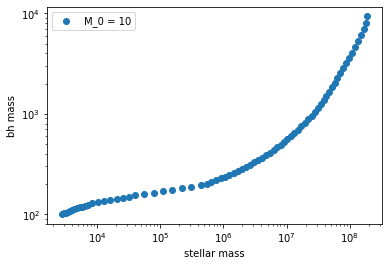

In [12]:

plt.scatter(sm_av, bh_av, label="M_0 = 10")
plt.legend()
plt.xlabel("stellar mass")
plt.ylabel("bh mass")
plt.yscale("log")
plt.xscale("log")


### Read in the heavy seeds

In [15]:
BRANCH_PER_TREE = 1
tree_ids, all_branches = get_all_branches()

working on tree 0
working on tree 1
working on tree 2
working on tree 3
working on tree 4
working on tree 5
working on tree 6
working on tree 7
working on tree 8
working on tree 9
working on tree 10
working on tree 11
working on tree 12
working on tree 13
working on tree 14
working on tree 15
working on tree 16
working on tree 17
working on tree 18
working on tree 19
working on tree 20
working on tree 21
working on tree 22
working on tree 23
working on tree 24
working on tree 25
working on tree 26
working on tree 27
working on tree 28
working on tree 29
working on tree 30
working on tree 31
working on tree 32
working on tree 33
working on tree 34
working on tree 35
working on tree 36
working on tree 37
working on tree 38
working on tree 39


In [19]:
# all_trees = grow_heavy_seeds(all_branches, 45*5, 0.1, 1e5)

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [28]:
tau, seed = 100,1e5
all_trees = grow_heavy_seeds(all_branches, tau, 0.1, seed)

names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_1.csv',index=False)

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_30948/1867817680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

# Doing something similar for Masafusa

"The exact host stellar masses we estimate are log M*/Msun ~ 10.6. So, probably 10^12.5 Msun makes sense."


In [28]:
m_h = np.logspace(7,14, 1000)
z = np.linspace(5,5, len(m_h))
low, up =  10.4, 10.8

m_star = calc_mass(m_h, z)
log_m_star = np.log10(m_star)

args = np.where((log_m_star >= low) & (log_m_star <= up))
low_mh, up_mh = np.min(m_h[args]), np.max(m_h[args])

mf = MassFunction()
dndm = mf.dndm
m = mf.m
args_hm = np.where((m>= low_mh) & (m <= up_mh))

m_filt = m[args_hm]
dndm_filt = dndm[args_hm]

dms = m_filt[1:] - m_filt[:-1]
dn = dndm_filt[:-1]*dms


cumsum = np.cumsum(dn)

N_trees = int(2000)
rans = np.random.uniform(low=np.min(cumsum), high=np.max(cumsum),size=N_trees)
m_h_target =interpolate.interp1d(cumsum, m_filt[:-1], kind='cubic',fill_value='extrapolate')(rans)

In [4]:
# N_trees = int(2000)

N_per_file = 100
working_dir = "trees_for_m"
N_files = int(N_trees/N_per_file)
catalog_base = "catalog_base.txt"
for x in range(N_files):
    number = str(x)
#     with io.open(working_dir+"/"+catalog_base, "r", newline='\n') as fin:
#         with io.open(working_dir+"/catalog"+number+".txt", "w", newline='\n') as fout:
#             for line in fin:
#                 if("mass" not in line):
#                     fout.write((line.replace('N', number)).replace('\r', ''))
#             #print(list(fout))
#             mhs = m_h_target[x*N_per_file:(x+1)*N_per_file]
#             for i in range(len(mhs)):
#                 newline = "{:e}".format(mhs[i])+"   0  " + number + "\n"
#                 fout.write(newline.replace('\r', ''))
#     fin.close()
#     fout.close()
    
#     with io.open(working_dir+"/skx_base", "r", newline='\n') as fin:
#         with io.open(working_dir+"/skx"+number, "w", newline='\n') as fout:
#             for line in fin:
#                 fout.write((line.replace('NUMBER', number)).replace('\r', ''))

    with io.open(working_dir+"/skx_find_base", "r", newline='\n') as fin:
        with io.open(working_dir+"/skx_find"+number, "w", newline='\n') as fout:
            for line in fin:
                fout.write((line.replace('NUMBER', number)).replace('\r', ''))




    fin.close()
    fout.close()
    
# with io.open(working_dir+"/submit_jobs_find.sh", "w", newline='\n') as fout:
#     fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
#     for x in range(N_files):
        
#         fout.write(("sbatch skx_find"+str(x)+"\n\n").replace('\r', ''))
#     fout.close()

# with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
#     fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
#     for x in range(N_files):
        
#         fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
#     fout.close()

# with io.open(working_dir+"/submit_jobs.sh", "w", newline='\n') as fout:
#     fout.write("#!/bin/bash\n\n\n".replace('\r', ''))
#     for x in range(N_files):
        
#         fout.write(("sbatch skx"+str(x)+"\n\n").replace('\r', ''))
#     fout.close()

### Read in the heavy seeds

Request from masafusa:

"We only have the accretion rates of BHs at the observed redshifts, as in other observations, and therefore we don’t have enough sensitivity to their seed BH masses. I would rather demonstrate that the observed BH mass (log Mbh / Msun = 9 at z=6.4) can be achieved by any seed mass range from stellar remnants to DCBHs, as is presented in your paper (when tau_efold = 40 Myr)"

"The exact host stellar masses we estimate are log M*/Msun ~ 10.6. So, probably 10^12.5 Msun makes sense."

"I prefer to have the median masses to compare with my JWST targets in time vs stellar/BH mass and stellar vs BH mass planes."

z=6.4
Mbh_target_pow = 9
Mstar_target_pow = 10.6

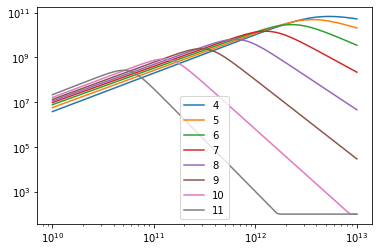

In [14]:
for z_tar in range(4,12,1):
    z_test = np.linspace(z_tar,z_tar,100)
    m_halo = np.logspace(10,13,100)
    stellar_mass = calc_mass_beh_2019(m_halo,z_test)
    plt.plot(m_halo, stellar_mass,label=str(z_tar))
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [5]:
BRANCH_PER_TREE = 1
# Z_SWITCH = 7
# Z_NEW = 5
Z_SCALE = 6.0/7.0#6.9/7.0
tree_ids, all_branches = get_all_branches(path="trees_for_m/dcbh_files")

working on tree 0
working on tree 1
working on tree 2
working on tree 3
working on tree 4
working on tree 5
working on tree 6
working on tree 7
working on tree 8
working on tree 9
working on tree 10
working on tree 11
working on tree 12
working on tree 13
working on tree 14
working on tree 15
working on tree 16
working on tree 17
working on tree 18
working on tree 19


C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_4048/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

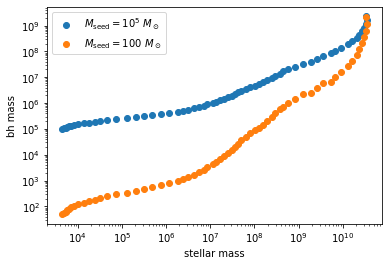

In [33]:
tau = 70
cap = 0.05
seed= 1e5
all_trees = grow_heavy_seeds(all_branches, tau, cap, seed)

z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)


names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_05.csv',index=False)




plt.scatter(sm_av, bh_av, label=r"$M_{\rm seed}=10^5 \ M_\odot$")

tau = 40
cap = 0.05
seed= 50
all_trees = grow_heavy_seeds(all_branches, tau, cap, seed)

z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
names = ["z", "median_bh_mass", "median_stellar_mass"]
z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)
data = np.array([z, bh_av,sm_av]).T
data = np.array(data)
df = pd.DataFrame(data,columns = names)
df.to_csv('mseed'+str(seed)+'_tau'+str(tau)+'_f0_05.csv',index=False)




plt.scatter(sm_av, bh_av, label=r"$M_{\rm seed}=100 \ M_\odot$")


plt.legend()
plt.xlabel("stellar mass")
plt.ylabel("bh mass")
plt.yscale("log")
plt.xscale("log")

plt.savefig("example_for_masafusa.pdf", bbox_inches="tight")

In [28]:
bh_av

array([5.00000000e+01, 5.59239208e+01, 6.27672664e+01, 7.06877999e+01,
       7.98939081e+01, 9.06288740e+01, 1.03202137e+02, 1.17979838e+02,
       1.35410357e+02, 1.56066766e+02, 1.80639840e+02, 2.10016807e+02,
       2.45281198e+02, 2.87790621e+02, 3.39303463e+02, 4.02007320e+02,
       4.78756089e+02, 5.73147499e+02, 6.89913355e+02, 7.69220117e+02,
       9.30950502e+02, 1.13342598e+03, 1.38789359e+03, 1.70999639e+03,
       2.12009179e+03, 2.64532631e+03, 3.32320806e+03, 4.20306731e+03,
       5.35336023e+03, 6.86966880e+03, 8.87972354e+03, 1.15689576e+04,
       1.51915227e+04, 2.01118984e+04, 2.68525295e+04, 3.61624848e+04,
       4.91374233e+04, 6.73893225e+04, 9.32954708e+04, 1.03684046e+05,
       1.44977945e+05, 2.04739506e+05, 2.92177753e+05, 4.21336516e+05,
       6.14433515e+05, 6.80768459e+05, 1.00393076e+06, 1.49802180e+06,
       2.26217540e+06, 2.49888093e+06, 3.82049722e+06, 5.91611526e+06,
       6.51586604e+06, 1.02237774e+07, 1.62579644e+07, 2.62188462e+07,
      

In [7]:
tau = 40
cap = 0.1
seed= 1e5
all_trees = grow_heavy_seeds(all_branches, tau, cap, seed)

z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)

plt.scatter(sm_av, bh_av, label="M_0 = 10")
plt.legend()
plt.xlabel("stellar mass")
plt.ylabel("bh mass")
plt.yscale("log")
plt.xscale("log")

10.541456485487158

In [17]:
BRANCH_PER_TREE = 1
# Z_SWITCH = 7
# Z_NEW = 5
Z_SCALE = 5.5/7.0
tree_ids, all_branches = get_all_branches(path="trees_for_m/dcbh_files")
tau = 40

cap = 0.1
seed= 1e5
all_trees = grow_heavy_seeds(all_branches, tau, cap, seed)

working on tree 0
working on tree 1
working on tree 2
working on tree 3
working on tree 4
working on tree 5
working on tree 6
working on tree 7
working on tree 8
working on tree 9
working on tree 10
working on tree 11
working on tree 12
working on tree 13
working on tree 14
working on tree 15
working on tree 16
working on tree 17
working on tree 18
working on tree 19


C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree["bh_mass"] = evolve_BH(tree["mass"], tree["time"], ft, cap,seed)
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:494: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_bh_mass = np.array([list(t["bh_mass"]) for t in all_trees])
C:\Users\Matthew\AppData\Local\Temp/ipykernel_32736/4253501931.py:495: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_sm = np.array([list(t["stellar_mass"]) for t in all_trees])


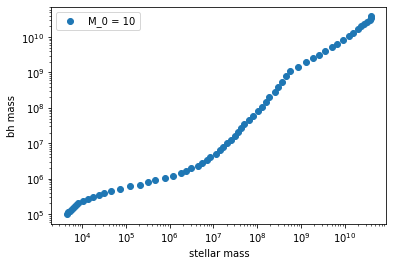

In [18]:

z, bh_av, bh_std,sm_av, sm_std = find_averages(all_trees,median=True)



plt.scatter(sm_av, bh_av, label="M_0 = 10")
plt.legend()
plt.xlabel("stellar mass")
plt.ylabel("bh mass")
plt.yscale("log")
plt.xscale("log")

In [19]:
np.max(np.log10(sm_av))

10.603252841511583